In [1]:

import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from einops import rearrange
from tqdm import tqdm
from geocube.api.core import make_geocube
from scipy.ndimage import generic_filter, gaussian_filter, convolve
import scipy.linalg as la
from shapely import Point, box
from rasterio.enums import Resampling
import seaborn as sns
import gc
from functools import cached_property
from dask.diagnostics import ProgressBar
from timeit import default_timer as timer
import dask.array as da
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.calibration import CalibratedClassifierCV
from tqdm import tqdm

# from dask_ml.preprocessing import StandardScaler
# from dask_ml.decomposition import PCA 

import cv2

root = Path.cwd()

In [ ]:
from dask.distributed import Client as da_client
from dask.distributed import LocalCluster

cluster = LocalCluster(
    n_workers=2,              
    threads_per_worker=1,     
    memory_limit='16GB',       
)
dask_client = da_client(cluster)
dask_client

<Client: 'tcp://127.0.0.1:61614' processes=2 threads=2, memory=29.80 GiB>

In [ ]:

class DataProcesser():
    def __init__(self, root, year, site_name,epsg,month_list):
        self.root = root
        self.year = year
        self.site_name = site_name
        self.epsg = epsg
        self.month_list = month_list

        standard_chunks = {'time':-1,'band':-1,'x':1831,'y':1831}

        aligned_data_path_nc = self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_aligned_bands.nc'
        aligned_data_path_zarr = self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_aligned_bands.zarr'
        if os.path.isfile(aligned_data_path_nc):
            self.data = xr.open_dataarray(aligned_data_path_nc)
            self.data = self.data.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()
        elif os.path.isdir(aligned_data_path_zarr):
            data = xr.open_zarr(aligned_data_path_zarr,chunks=standard_chunks)
            self.data = data[list(data.data_vars.keys())[0]]
            self.data = self.data.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()
        else:
            self.data = None

        self.x_coords = self.data.x.values
        self.y_coods = self.data.y.values
        
        variables_path_nc = self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_variables.nc'
        variables_path_zarr = self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_variables.zarr' 
        if os.path.isfile(variables_path_nc):
            self.variables = xr.open_dataarray(variables_path_nc)
        elif os.path.isdir(variables_path_zarr):
            variables = xr.open_zarr(variables_path_zarr,chunks=standard_chunks)
            self.variables = variables[list(variables.data_vars.keys())[0]]

        else:
            self.variables = None   

        diff_path = self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_diffs_summerminusspring.nc'
        if os.path.isfile(diff_path):
            self.diff = xr.open_dataarray(diff_path,chunks={'band':-1,'y':standard_chunks['y'],'x':standard_chunks['x']})
            self.diff = self.diff.assign_coords({'band':['diff_evi','diff_lswi','diff_slavi','diff_psri']})

        else:
            self.diff = None


        # make sure dimension order matches
        if self.data is not None and self.data.dims != ('time','band','y','x'):
                self.data = self.data.transpose('time','band','y','x')
        
        if self.variables is not None and self.variables.dims != ('time','band','y','x'):
                self.variables = self.variables.transpose('time','band','y','x')
        
        if self.diff is not None and self.diff.dims != ('band','y','x'):
            self.diff = self.diff.transpose('band','y','x')

        lsp = rioxarray.open_rasterio(root / 'LSP_data' / 'greenup_date.tif')
        lsp = lsp.rio.reproject_match(self.data.isel(band=1), resampling=Resampling.bilinear)
        self.lsp = lsp.squeeze()


    
    def get_gradient(self, im) :
        # Calculate the x and y gradients using Sobel operator
        grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
        grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
        # Combine the two gradients
        grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)

        return grad
    
    

    
    # coregister data and save
    def coregister_data(self):
        # open raw sentinel data file
        data = xr.open_dataarray(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}.nc')

        data = data.astype('float32') # convert from float64 to save memory
        # set nans to 0
        b_sel = xr.where(~np.isnan(data), data, 0)

        # create reference image: mean of all temporal steps
        reference_image = data.mean(dim=['band','time'])
        # replace na with 0 
        reference_image = xr.where(~np.isnan(reference_image),reference_image,0)
        # convert to numpy array
        reference_image = reference_image.to_numpy()

        # define dimensions for output image
        height = b_sel.shape[2]
        width = b_sel.shape[3]
        time = b_sel.shape[0]
        band = b_sel.shape[1]

        ## Define motion model
        #warp_mode = cv2.MOTION_AFFINE
        warp_mode = cv2.MOTION_TRANSLATION

        # Set the stopping criteria for the algorithm.
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

        # Create empty array of correct size for new aligned images
        im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )

        scale = 0.1  # downscale to 10% of original size
        small_ref = cv2.resize(reference_image, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        small_ref_image_gradient = self.get_gradient(small_ref)

        #im = b_sel.to_numpy()
        # loop over time and band dimensions and apply coregistration to each band
        # calculate warp_matrix for only one band per timestamp and apply to all bands
        for i in tqdm(range(0,time)):
            im = b_sel.isel(time=i).to_numpy()  # shape: (band, y, x)
            # get just red band and downsample im for calculating warp matrix
            red_band = im[2,:,:]
            small_red_band = cv2.resize(red_band,None,fx=scale,fy=scale,interpolation=cv2.INTER_AREA)
            red_gradient = self.get_gradient(small_red_band)
            
            # set empty warp matrix
            warp_matrix = np.eye(2, 3, dtype=np.float32)
            # calculate warp matrix based on downsampled red band and reference image
            (_, warp_matrix) = cv2.findTransformECC(small_ref_image_gradient, red_gradient, warp_matrix, warp_mode, criteria) 
            
            # apply transformation to each band 
            for j in range(0,band):                                
                im_aligned[i,j,:,:] = cv2.warpAffine(im[j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
            
            del im
            gc.collect() # free memory
            
                

        b_align = xr.DataArray(im_aligned, 
                        coords={'time':b_sel.time,'band': b_sel.band,'y': b_sel.y,'x':b_sel.x}, 
                        dims=['time','band','y','x'])
        # reset 0 values to na
        b_align = xr.where(b_align == 0, np.nan, b_align)

        self.aligned_data = b_align
        b_align.to_netcdf(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_aligned_bands.nc')
        print(f'coregisterd bands saved to {self.root} / sentinel_data / {self.site_name} / {self.year}_{self.site_name}_aligned_bands.nc')

    # calculate variables and save
    def remove_outliers(self,a,min,max):  # slavi: 0-20, psri: -0.5 - 1.0
    #a = a.where(np.isfinite(a),np.nan)
        a = xr.where(np.isfinite(a),a,np.nan)
        a = a.clip(min=min,max=max)
        return a
    
    def get_variables(self):
        blue = self.data.sel(band='B02')
        #green = self.aligned_data.sel(band='B03')
        red = self.data.sel(band='B04')
        nir = self.data.sel(band='B8A')
        sw1 = self.data.sel(band='B11')
        sw2 = self.data.sel(band='B12')
        re2 = self.data.sel(band='B06')


        evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1)).expand_dims({'band':['evi']}) 
        lswi = (nir - sw1)/(nir + sw1).expand_dims({'band':['lswi']}) 
        slavi = nir/(red + sw2).expand_dims({'band':['slavi']}) 
        psri = (red - blue)/re2.expand_dims({'band':['psri']}) 

        # bright = (0.3510*blue)+(0.3813*green)+(0.3437*red)+(0.7196*nir)+(0.2396*sw1)+(0.1949*sw2).expand_dims({'band':[f'bright_{season_list[i]}']})
        # bright = self.remove_outliers(bright)

        # wet = (0.2578*blue)+(0.2305*green)+(0.0883*red)+(0.1071*nir)+(-0.7611*sw1)+(-0.5308*sw2).expand_dims({'band':[f'wet_{season_list[i]}']})
        # wet = self.remove_outliers(wet)

        # green = (-0.3599*blue)+(-0.3533*green)+(-0.4734*red)+(0.6633*nir)+(0.0087*sw1)+(-0.2856*sw2).expand_dims({'band':[f'green_{season_list[i]}']})
        # green = self.remove_outliers(green)

        evi = self.remove_outliers(evi,min=-1,max=1)
        lswi = self.remove_outliers(lswi,min=-1,max=1)
        slavi = self.remove_outliers(slavi,min=0,max=20)
        psri = self.remove_outliers(psri,min=-0.5,max=1.0)

        all_vars = xr.concat([evi,lswi,slavi,psri],dim='band')
        # ## mask non-forest pixels
        # self.all_variables = m3.where(m3.sel(band=f'evi_month{num_of_peak_evi_month}')>0.5,other=np.nan)
        all_vars = xr.where(all_vars.isel(time=1,band=0)>=0.5,all_vars,np.nan)

        # # save
        all_vars.to_netcdf(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_variables.nc')
        self.variables = all_vars

    
    
    

    def get_variable_diffs(self,spring_index=0,summer_index=1):

        d = self.variables.isel(time=summer_index) - self.variables.isel(time=spring_index)

        self.diff = d

        d.to_netcdf(self.root / 'sentinel_data' / self.site_name /  f'{self.year}_{self.site_name}_diffs_summerminusspring.nc')
        print(f'diffs saved to {self.root }/sentinel_data/{self.site_name}/{self.year}_{self.site_name}_diffs_summerminusspring.nc')
    

    def flatten_months(self,a):

        array_list1 = list()
        for i, month in enumerate(self.month_list):
            t = a.isel(time=i).reset_coords('time',drop=True)
            t = t.assign_coords({'band':[f'{month}_{x}' for x in a.band.values]})
            array_list1.append(t)

        m = xr.concat(array_list1,dim='band')

        return m
    
    @cached_property
    def array_3d(self):

        m1 = self.flatten_months(self.data)
        m2 = self.flatten_months(self.variables)

        # make sure order of dimensions match
        transposed = []
        for x in [m1,m2,self.diff]:
            if x.dims != ('y', 'x', 'band'):
                x = x.transpose('y', 'x', 'band')
            transposed.append(x)

        m1, m2, diff = transposed

        t = xr.concat([m1,m2,diff],dim='band')

        return t
    
    
    def run_pca(self,n=15,lsp_mask=None,output_desc='v0'):

        t = self.array_3d

        if lsp_mask:
            lsp = rioxarray.open_rasterio(self.root / 'LSP_data' / 'greenup_date.tif')
            lsp = lsp.rio.reproject_match(t.isel(band=1), resampling=Resampling.bilinear)
            lsp = lsp.squeeze()

            if lsp_mask == 'after_mean_gu_date':
                t = t.where(lsp > 115)
            else:
                t = t.where(lsp <= 115)
        

        a_2d = rearrange(t.values, 'h w c -> (h w) c')

        valid_mask = ~np.isnan(a_2d).any(axis=1)
        # drop all na from data
        a2d_dropna = a_2d[valid_mask]

        # rescale data around approximate mean of 0
        scaler = StandardScaler()
        # scaling data
        data_scaled = scaler.fit_transform(a2d_dropna)

        pca = PCA(n_components=n, svd_solver='randomized')
        print('starting fit')
        pca.fit(data_scaled)
        print('starting transform')
        pca_data = pca.transform(data_scaled)
        print(f'explained variance: {np.cumsum(pca.explained_variance_ratio_)}')

        # create array of correct shape
        output_array_2d = np.full((a_2d.shape[0],n), np.nan) 
        output_array_2d[valid_mask] = pca_data

        # # reshape to original dimensions
        height = t.shape[0]
        width = t.shape[1]
        new_pca_data = rearrange(output_array_2d, '(h w) c -> c h w', h=height, w=width)
        pca_array = xr.DataArray(new_pca_data, 
                        coords={'band': np.arange(0,n),'y': t.y,'x': t.x}, 
                        dims=['band','y','x'])
        
        pca_array.to_netcdf(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_pca_{output_desc}.nc')
        print(f'pca saved to {self.root}/sentinel_data/{self.site_name}/{self.year}_{self.site_name}_pca_{output_desc}.nc')

        return pca_array

    # make mnf input stack
    def make_mnf_input(self,month,pca_version):

        t = self.array_3d

        e = [x for x in t.band.values if (any(y in x for y in [month, 'diff']))]
        a = t.sel(band=e)

        pca = xr.open_dataarray(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_pca_{pca_version}.nc')

        s = xr.concat([a,pca],dim='band')

        s.to_netcdf(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_mnfinputstack_{pca_version}.nc')

        return s
    
    


class DataProcesserZarr(DataProcesser):
     
    def save_data_stack(self, version):

        f = self.flatten_months(self.data)
        fv = self.flatten_months(self.variables)

        t = xr.concat([f,fv,self.diff],dim='band')

        t = t.chunk({'band':10,'y':None,'x':None}).persist()  

        if version == 'aftermeangu':
            t = xr.where(self.lsp > 115, t, np.nan)
        else:
            t = xr.where(self.lsp <= 115, t, np.nan)

        t.to_zarr(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_data_stack_{version}.zarr')


    def run_pca(self,version):

        f = self.flatten_months(self.data)
        fv = self.flatten_months(self.variables)

        t = xr.concat([f,fv,self.diff],dim='band')

        t = t.chunk({'band':10,'y':None,'x':None}).persist()  # persisting rechunked data speeds processing

        if version == 'aftermeangu':
            t = xr.where(self.lsp > 115, t, np.nan)
        else:
            t = xr.where(self.lsp <= 115, t, np.nan)

        a_2d = t.stack(pixel=('y', 'x')).transpose('pixel', 'band')

        valid_mask = ~da.isnan(a_2d).any(axis=1).compute()
        # drop all na from data
        a2d_dropna = a_2d[valid_mask].compute() ####### convert to numpy for PCA

        # rescale data around approximate mean of 0
        scaler = StandardScaler()
        # scaling data
        data_scaled = scaler.fit_transform(a2d_dropna)

        pca = PCA(n_components=15, svd_solver='randomized')
        print('starting fit')
        pca.fit(data_scaled)
        print('starting transform')
        pca_data = pca.transform(data_scaled)
        print(f'explained variance: {np.cumsum(pca.explained_variance_ratio_)}')

        #create array of correct shape
        output_array_2d = np.full((a_2d.shape[0],15), np.nan) 
        output_array_2d[valid_mask] = pca_data

        # # reshape to original dimensions
        height = t.shape[0]
        width = t.shape[1]
        new_pca_data = rearrange(output_array_2d, '(h w) c -> c h w', h=height, w=width)
        pca_array = xr.DataArray(new_pca_data, 
                        coords={'band': np.arange(0,15),'y': t.y,'x': t.x}, 
                        dims=['band','y','x'])

        pca_array.to_netcdf(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_pca_{version}.nc')

        return pca

    def get_variables(self):

        month1 = xr.open_zarr(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_aligned_{self.month_list[0]}.zarr',chunks='auto')
        var_name = list(month1.data_vars.keys())[0]
        month1 = month1[var_name]

        month2 = xr.open_zarr(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_aligned_{self.month_list[1]}.zarr',chunks='auto')
        var_name = list(month2.data_vars.keys())[0]
        month2= month2[var_name]

        month3 = xr.open_zarr(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_aligned_{self.month_list[2]}.zarr',chunks='auto')
        var_name = list(month3.data_vars.keys())[0]
        month3 = month3[var_name]

        months = xr.concat([month1,month2,month3], dim='time')

        months = months.chunk('auto')

        months.to_zarr(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_aligned_bands.zarr')
        self.data = months
            
            
        blue = months.sel(band='B02')
        red = months.sel(band='B04')
        nir = months.sel(band='B8A')
        sw1 = months.sel(band='B11')
        sw2 = months.sel(band='B12')
        re2 = months.sel(band='B06')


        evi = (2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1)).expand_dims({'band':['evi']})).persist() 
        lswi = ((nir - sw1)/(nir + sw1).expand_dims({'band':['lswi']})).persist()
        slavi = (nir/(red + sw2).expand_dims({'band':['slavi']})).persist()
        psri = ((red - blue)/re2.expand_dims({'band':['psri']})).persist()



        evi = self.remove_outliers(evi,min=-1,max=1)
        lswi = self.remove_outliers(lswi,min=-1,max=1)
        slavi = self.remove_outliers(slavi,min=0,max=20)
        psri = self.remove_outliers(psri,min=-0.5,max=1.0)

        all_vars = xr.concat([evi,lswi,slavi,psri],dim='band')
        # ## mask non-forest pixels
        
        all_vars = xr.where(all_vars.isel(time=1,band=0)>=0.5,all_vars,np.nan)
        self.variables = all_vars
        # # save
        all_vars.to_zarr(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_variables.zarr')


    def create_mnf_input(self,version):
        # this function old: just use pca for mnf input
        f = self.flatten_months(self.data)
        fv = self.flatten_months(self.variables)

        t = xr.concat([f,fv,self.diff],dim='band')

        e = [x for x in t.band.values if (any(y in x for y in ['august', 'diff']))]

        a = t.sel(band=e)

        if version == 'aftermeangu':
            a = xr.where(self.lsp > 115, a, np.nan)
        else:
            a = xr.where(self.lsp <= 115, a, np.nan)

        # make sure chunks are aligned
        pca = xr.open_dataarray(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_pca_{version}.nc',chunks={'y':a.chunksizes['y'][0],'x':a.chunksizes['x'][0],'band':a.chunksizes['band'][0]})

        s = xr.concat([a,pca],dim='band')

        s.to_zarr(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_mnfinputstack_{version}.zarr')



    def coregister_data(self):

        m1 = xr.open_zarr(root / 'sentinel_data' / 'watershed' / f'{self.year}_clean_data_{self.month_list[0]}.zarr',chunks='auto')
        var_name = list(m1.data_vars.keys())[0]
        m1 = m1[var_name].expand_dims({'time':[self.month_list[0]]})

        m2 = xr.open_zarr(root / 'sentinel_data' / 'watershed' / f'{self.year}_clean_data_{self.month_list[1]}.zarr',chunks='auto')
        var_name = list(m2.data_vars.keys())[0]
        m2 = m2[var_name].expand_dims({'time':[self.month_list[1]]})

        m3 = xr.open_zarr(root / 'sentinel_data' / 'watershed' / f'{self.year}_clean_data_{self.month_list[2]}.zarr',chunks='auto')
        var_name = list(m3.data_vars.keys())[0]
        m3 = m3[var_name].expand_dims({'time':[self.month_list[2]]})

        months = xr.concat([m1,m2,m3], dim='time')

        months = months.chunk('auto')

        b_sel = xr.where(~np.isnan(months), months, 0)

        # create reference image: mean of all temporal steps
        reference_image = months.mean(dim=['band','time'])
        # replace na with 0 
        reference_image = xr.where(~np.isnan(reference_image),reference_image,0)
        # convert to numpy array
        reference_image = reference_image.to_numpy()

        # define dimensions for output image
        height = b_sel.shape[2]
        width = b_sel.shape[3]
        time = b_sel.shape[0]
        band = b_sel.shape[1]

        ## Define motion model
        #warp_mode = cv2.MOTION_AFFINE
        warp_mode = cv2.MOTION_TRANSLATION

        # Set the stopping criteria for the algorithm.
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

        ref_image_gradient = self.get_gradient(reference_image)

        # loop over time and band dimensions and apply coregistration to each band
        # calculate warp_matrix for only one band per timestamp and apply to all bands
        for i in range(0,time):
            
            im = b_sel.isel(time=i).to_numpy()  # shape: (band, y, x)

            monthname = b_sel.time.values[i]
            # get just red band and downsample im for calculating warp matrix
            red_band = im[2,:,:]
            # small_red_band = cv2.resize(red_band,None,fx=scale,fy=scale,interpolation=cv2.INTER_AREA)
            # red_gradient = get_gradient(small_red_band)
            red_gradient = self.get_gradient(red_band)
            
            # set empty warp matrix
            warp_matrix = np.eye(2, 3, dtype=np.float32)
            # calculate warp matrix based on red band and reference image
            (_, warp_matrix) = cv2.findTransformECC(ref_image_gradient, red_gradient, warp_matrix, warp_mode, criteria) 
            print(warp_matrix)
            # apply transformation to each band 
            im_aligned = np.zeros((band,height,width), dtype=np.float32 )
            for j in range(0,band):                                
                im_aligned[j,:,:] = cv2.warpAffine(im[j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
            
            del im
            gc.collect() # free memory

            b_align = xr.DataArray(im_aligned[np.newaxis, ...], 
                        coords={'time':[monthname],'band': b_sel.band,'y': b_sel.y,'x':b_sel.x}, 
                        dims=['time','band','y','x'])
            
            b_align = b_align.chunk('auto')
            # reset 0 values to na
            b_align = xr.where(b_align == 0, np.nan, b_align)

            b_align.to_zarr(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_aligned_{monthname}.zarr',mode='w')




        


In [12]:
w = DataProcesserZarr(root=root, year=2022, site_name='watershed',epsg=26918,month_list=['may','august','october'])

In [ ]:
w.save_data_stack(version='aftermeangu')

In [ ]:
w.run_pca(lsp_mask='beforemeangu')

starting fit
starting transform
explained variance: [0.36289847 0.6640425  0.8124583  0.8641128  0.8986389  0.9248797
 0.94391465 0.9586935  0.96610844 0.97228    0.97705793 0.98125565
 0.98511153 0.9881089  0.9902112 ]


In [3]:
cat_data = DataProcesser(root, '2022', 'catskills',26918)

In [23]:
cat_data.get_variable_diffs(spring_index=0,summer_index=1)

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/catskills/2022_catskills_diffs_summerminusspring.nc


In [9]:
t = cat_data.run_pca(lsp_mask='before_mean_gu_date',output_desc='beforemeangudate')

starting fit
starting transform
explained variance: [0.35984507 0.5828134  0.7287644  0.79790765 0.85821325 0.8982209
 0.91921705 0.9373099  0.9518837  0.96034074 0.9675531  0.9726231
 0.976588   0.9795628  0.982117  ]
pca saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/catskills/2022_catskills_pca_beforemeangudate.nc


In [ ]:
cat_data.make_mnf_input(month='july',pca_version='beforemeangu')


In [ ]:
# Routh: use quadratic mean to weight higher variance bands.
# use pca (Gudex-Cross also does this to reduce correlation between bands)
# shift difference calculation performed on all pca components.
# should give a more accurate estimate of noise in data than scaling gaussian noise.
# Follows methods shown in Routh and described in ENVI documention.
# adding uniform noise to pca bands does not conform to published methods; likely mis-estimates actual amount of noise and affects downstream detection of signal.


In [2]:
# data = xr.open_dataarray(root / 'sentinel_data' / 'watershed' / f'2022_watershed_pca_aftermeangu.nc',chunks='auto')
# data = data.transpose('band','y','x')

data = xr.open_dataarray(root / 'sentinel_data' / 'bart' / '2019_bart_pca_ssf_nontc2_diffspring.nc')


In [ ]:
# numpy version
def find_noise_region_numpy(data):
    # calculate std in moving window
    data_std = data.rolling(x=5,y=5).std()

    std2 = (data_std**2).where(np.isfinite(data_std))
    band_count = std2.count(dim='band')                         
    rms = np.sqrt( (std2.sum(dim='band')) / band_count )  # root mean square across bands

    flattened = rms.stack(flat=['x', 'y'])

    threshold = np.nanquantile(flattened, 0.10, axis=0) # tenth percentile

    variance_filled = rms.fillna(np.inf)  
    low_var = variance_filled <= threshold
    binary_mask = low_var.astype(np.uint8)

    binary_mask_computed = binary_mask.compute().values

    # Find contours of homogeneous regions
    contours, _ = cv2.findContours(binary_mask_computed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ##### select region for shift difference calculation

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    region = data.isel(y=slice(y, y+h), x=slice(x, x+w))
    region = region.transpose('y','x','band')
    img = region.values
    
    # plot location of noise region
    b = box(xmin=x,ymin=y,xmax=w+x,ymax=y+h)
    g = gpd.GeoSeries([b])
    fig, ax = plt.subplots()
    plt.imshow(data[0,:,:])
    g.plot(ax=ax,facecolor='none',edgecolor='red')

    return img

##### dask version ########
def find_noise_region_dask(data):
    # find regions with low variance
    # Routh uses regions of ~200 pixels

    # 13 x 13 resolution 
    coarsened = data.coarsen(x=13, y=13, boundary='pad') # coarsen faster than rolling
    block_std = coarsened.std()

    std2 = (block_std**2).where(np.isfinite(block_std))
    band_count = std2.count(dim='band')                         
    rms_blocks = np.sqrt( (std2.sum(dim='band')) / band_count )  # root mean square across bands

    flattened = rms_blocks.stack(flat=['x', 'y'])

    threshold = da.nanquantile(flattened.data, 0.10,axis=0).compute() # threshold = 10th percentile

    rms = rms_blocks.interp_like(
            data.isel(band=0), 
            method='nearest'
        )

    variance_filled = rms.fillna(np.inf)  
    low_var = variance_filled <= threshold
    binary_mask = low_var.astype(np.uint8)

    binary_mask_computed = binary_mask.compute().values  # compute binary mask

    # Find contours of homogeneous regions
    contours, _ = cv2.findContours(binary_mask_computed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ##### select region for shift difference calculation
    # Take all regions larger than mean size
    sizes = [cv2.contourArea(c) for c in contours]
    mean_size = np.mean(sizes)
    above_mean = [i for (i,size) in enumerate(sizes) if size >= mean_size]
    keep = [contours[i] for i in above_mean]

    noise_regions = []
    for contour in keep:
        x, y, w, h = cv2.boundingRect(contour)
        noise_region = data.isel(y=slice(y, y+h), x=slice(x, x+w))
        noise_regions.append(noise_region)

    # select patch with most valid pixels
    m = [x.isel(band=0).count() for x in noise_regions]

    i = np.argmax(m)
    region = noise_regions[i]
    region = region.transpose('y','x','band')

    img = region.values
    # plot location of noise region
    d = data.isel(band=0).values
    b = box(xmin=x,ymin=y,xmax=w+x,ymax=y+h)
    g = gpd.GeoSeries([b])
    fig, ax = plt.subplots()
    plt.imshow(d)
    g.plot(ax=ax,facecolor='none',edgecolor='red')

    del(d)

    return img

def get_noise_cov(img):
    # estimate noise through shift difference calculation
    # based on ENVI documentation: https://www.nv5geospatialsoftware.com/docs/MinimumNoiseFractionTransform.html
    # and spectral python package: https://github.com/spectralpython/spectral/blob/master/spectral/algorithms/algorithms.py#L1434

     ###### this method is different than before because:
    # i use just pca rather than bands/indices; avoids redundant information and interband correlation.
    # i locate homogenous patches based on rms below 10th percentile rather than variance below median.
    # i use shift difference approach to estimate noise rather than scaling uniform gaussian noise; shift difference is widely used.
    # estimating noise on multi-temporal data stack leads to ill-conditioned matrix because of correlation between bands
    H, W, B = img.shape

    rh = (img[:, 1:, :] - img[:, :-1, :]) / np.sqrt(2.0)
    rv = (img[1:, :, :] - img[:-1, :, :]) / np.sqrt(2.0)

    R = np.concatenate([
    rh.reshape(-1, B),
    rv.reshape(-1, B)
    ], axis=0)

    R  = R[np.all(np.isfinite(R), axis=1)]

    # covariance matrix
    cov = np.cov(R, rowvar=False)     

    print(f'determinant: {np.linalg.det(cov)}\ncondition: {np.linalg.cond(cov)}')

    return cov

def create_mnf(cov, data, year, site, chunked=True):
    # cov: noise covariance matrix 
    # data: pca as xarray with dims ('y','x','band')- if dask chunked = True

    w, V = np.linalg.eigh(cov)                         
    W = (V / np.sqrt(w)) @ V.T    # whitening matrix
    W32 = W.astype('float32')
                
    # Keep all bands in one chunk
    if chunked:
        data = data.astype('float32').chunk({'band': -1, 'y': 1024, 'x': 1024})
    else:
        data = data.astype('float32')
    # Center per band (across pixels)
    mu = data.mean(dim=('y','x'), skipna=True)
    Xc = data - mu

    # convert whitening matrix to data array
    W_da = xr.DataArray(W32,
        coords={'band_out': data.band.values, 'band': data.band.values},
        dims=('band_out','band'))
    X_whitened = xr.dot(W_da, Xc, dims=['band']).rename({'band_out': 'band'}) # apply whitening matrix to centered data


    Xw_2d = X_whitened.stack(pix=('y','x'))                # reshape whitened data to 2d
    Xw_2d = Xw_2d.dropna(dim='pix',how='any')                    # remove nans
    Xw_2d = Xw_2d - Xw_2d.mean('pix')                 # mean center in whitened space

    # PCA on whitened data
    Xw_T = Xw_2d.rename({'band':'band2'}).transpose('pix','band2')  # transpose array and rename band dimension

    S_w = xr.dot(Xw_2d,Xw_T,dims=['pix']) / (Xw_2d.sizes['pix']-1)

    S_w = S_w.compute().values.astype('float64') # compute the covariance matrix of the whitened data

    lam, U = np.linalg.eigh(S_w)                        
    idx = lam.argsort()[::-1]            # sort SNR descending
    lam, U = lam[idx], U[:, idx]                
    A = xr.DataArray(U.T.astype('float32'),
        coords={'comp': np.arange(U.shape[1]), 'band': data.band},
        dims=('comp','band'))

    Y = xr.dot(A, X_whitened, dims=['band']).compute()

    
    Y.to_netcdf(root / 'sentinel_data' / site / f'{year}_{site}_mnf.nc')
    print(f'MNF image saved to {root} / sentinel data / {site} / {year}_{site}_mnf.nc')


def get_endmembers(ba, mnf, endmember_thresh,version=None,epsg=26918):  
    # ba: basal area dataset for site
    # mnf: mnf image for site

        # add crs to input rasters
        mnf_geo = mnf.rio.write_crs(epsg).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()
        ba_geo = ba.rio.write_crs(epsg).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()
        
        basal_area = ba_geo.rio.reproject_match(mnf_geo.isel(comp=0),resampling=Resampling.bilinear)
        basal_area = ba['beech_basal_area']
        
        basal_area_masked = basal_area.where(mnf.isel(comp=0))

        stacked = basal_area_masked.stack(pixel=('y','x'))
        
        mask = (stacked>=endmember_thresh).compute()
        
        selected = stacked.where(mask,drop=True)

        y_idx_coords = selected.indexes['pixel'].get_level_values('y')
        x_idx_coords = selected.indexes['pixel'].get_level_values('x')

        y_idx = mnf.get_index('y').get_indexer(y_idx_coords)
        x_idx = mnf.get_index('x').get_indexer(x_idx_coords)

        endmembers_mnf_da = mnf.isel(y=(xr.DataArray(y_idx, dims='points')),  # vectorized indexing of paired points
                                x=(xr.DataArray(x_idx, dims='points')))

        
        endmembers_mnf = endmembers_mnf_da.compute().values  ## convert to numpy
            
        if version == 'aftermeangu':
            endmembers_mnf = np.delete(endmembers_mnf,3,axis=1)  # remove site with heavy bbd/necrosis

        endmembers_mean = np.nanmean(endmembers_mnf, axis=1)

        # get number of components that include 99% of signal
        K = np.searchsorted(np.cumsum(endmembers_mean**2) / (endmembers_mean**2).sum(), 0.99) + 1

        return endmembers_mnf, endmembers_mean, K

def mixture_tune_matched_filter(mnf_image,e_mean,K,year,site):

    mnf_K = mnf_image.isel(comp=slice(0,K))
    # covariance matrix of K mnf compnents
    mnf_2d = mnf_K.stack(pixel=('y','x')).transpose('pixel','comp')
    X = mnf_2d.dropna(dim='pixel', how='any').data            # (Npix, B), dask
    mu = da.mean(X, axis=0, keepdims=True)
    Xc = X - mu   # mean center data
    mnf_2d_centered = mnf_2d - mu # also center data with nans retained
    N  = X.shape[0]
    S  = (Xc.T @ Xc) / (N - 1)                                
    S  = S.compute().astype(np.float64)

    # center target using same mean
    target = e_mean[:K]
    s = (target - mu).astype(np.float64)
    s = s.reshape(-1)


    L = np.linalg.cholesky(0.5*(S+S.T))                  # SPD check
    u = la.cho_solve((L, True), s)                       # C^{-1} s
    den = float(s @ u)
    w = (u / den).astype(np.float32)                     # (K,)

    # Scores for all pixels 
    scores = (mnf_2d_centered.data @ w).compute()   

    scores_da = xr.DataArray(
        scores,
        coords={'pixel': mnf_2d.coords['pixel']},
        dims=['pixel']
    ).unstack('pixel') 


    ## infeasibility
    s32 = np.asarray(s, dtype=np.float32)                # s = mean centered target spectra         # (K,)
    R = mnf_2d_centered - scores[:, None] * s32[None, :] 


    lam = np.diag(S)   # diagonal of mnf covariance matrix
    lam = np.asarray(lam, dtype=np.float32)                       # (K,)
    sigma = np.sqrt(lam)                                          
    a_clamped = da.clip(scores, 0.0, 1.0)                              
    NU = ((1.0 - a_clamped[:, None]) * sigma[None, :] + a_clamped[:, None]) ** 2  # (N,K)
    NU = da.maximum(NU, 1e-6) 

    IF = da.sqrt(da.sum((R * R) / NU, axis=1))                    # (N,)

    # Back to (y,x)
    IF_da = xr.DataArray(IF, coords={'pixel': mnf_2d.coords['pixel']},
                        dims=['pixel']).unstack('pixel')
    
    scores_da.to_netcdf(root / 'sentinel_data' / site / f'{year}_{site}_mf_scores.nc')
    IF_da.to_netcdf(root / 'sentinel_data' / site / f'{year}_{site}_infeas_scores.nc')
    print(f'MF scores saved to {root} / sentinel_data / {site} / f{year}_{site}_mf_scores.nc')
    print(f'Infeas scores saved to {root} / sentinel_data / {site} / f{year}_{site}_infeas_scores.nc')


C:\Users\roseh\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


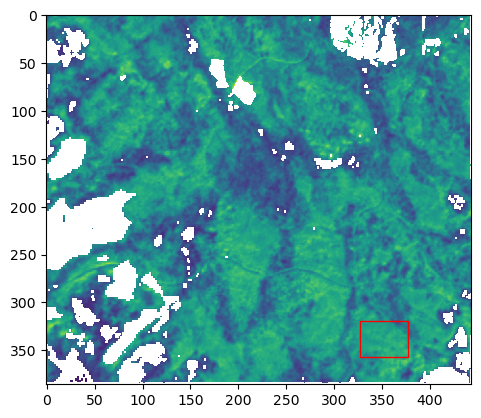

In [4]:
noise_region = find_noise_region_numpy(data)

In [5]:
cov = get_noise_cov(noise_region)

determinant: 1.575284158719764e-19
condition: 49.32587948831332


In [ ]:
# MNF
create_mnf(cov=cov, data=data, year=2019, site='bart',chunked=False)

MNF image saved to c:\Users\roseh\My Drive\beech_tree\beech_tree / sentinel data / bart / 2019_bart_mnf.nc


In [ ]:
# open basal area and mnf rasters
bart_basal_area = xr.open_dataset(root / 'output' / 'BART' / 'basal_area_bart.nc')
bart_mnf = xr.open_dataarray(root / 'sentinel_data' / 'bart' / '2019_bart_mnf.nc')

# extract endmember spectra
e_mnf, e_mean, K = get_endmembers(ba=bart_basal_area, mnf=bart_mnf, endmember_thresh=100.0,version=None)

# calculate and save matched filter and infeasibility scores
mixture_tune_matched_filter(bart_mnf,e_mean=e_mean,K=K,year=2019,site='bart')

In [ ]:
mnf = xr.open_dataarray(root / 'sentinel_data' / 'watershed' / 'mnf_beforemeangu.nc', chunks='auto')
mnf = mnf.rio.write_crs(26918).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()
mnf_2d = mnf.stack(pixel=('y','x')).transpose('pixel','comp')

basal_area = xr.open_dataset(root / 'output' / 'catskills' / f'basal_area_CATSKILLS.nc',chunks='auto')
basal_area = basal_area.astype(np.float32)
basal_area = basal_area.rio.write_crs(26918).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()

# align basal area and mnf rasters
basal_area = basal_area.rio.reproject_match(mnf.isel(comp=0),resampling=Resampling.bilinear)
beech_basal_area = basal_area['beech_basal_area']
# add beech category to dataset
beech_category = xr.where(beech_basal_area == 100, 1.0, 
                        xr.where(beech_basal_area == 0, 0.0, 2.0))
basal_area['beech_category'] = beech_category


In [33]:
np.nanpercentile(IF_da.values, [50, 95, 99, 99.9])

array([ 2.71134138, 10.98892117, 21.04062996, 72.9775885 ])

In [ ]:
def regularize_matrix(N, kappa_target=1e6, rel_floor=1e-12, shrink=0.0):
    """
    N: noise covariance (B,B), symmetric PSD
    kappa_target: desired cond number cap (1e4–1e6 is typical)
    rel_floor: also floor by rel_floor * mean(diag(N)) to avoid extreme tiny modes
    shrink: optional 0..1 shrinkage to diagonal: N <- (1-shrink)N + shrink*diag(N)
    """
    N = np.asarray(N, dtype=np.float64)
    # Optional diagonal shrink to reduce off-diagonal noise correlation a bit
    if shrink > 0:
        D = np.diag(np.diag(N))
        N = (1 - shrink) * N + shrink * D

    w, V = np.linalg.eigh(N)  # w sorted ascending
    # Two floors: by condition target AND absolute scale
    floor_kappa = w.max() / kappa_target
    floor_abs   = rel_floor * np.mean(np.diag(N))
    floor = max(floor_kappa, floor_abs)

    w_clipped = np.maximum(w, floor)
    N_reg = (V * w_clipped) @ V.T       # V @ diag(w_clipped) @ V.T
    kappa = w_clipped.max() / w_clipped.min()
    return N_reg, {"floor": floor, "kappa": kappa, "min_eig": w_clipped.min(), "max_eig": w_clipped.max()}

In [13]:
r = MnfImage(root,'watershed','2022','beforemeangu')

noise_region = r.get_noise_region_variance()

In [ ]:
class MnfImage():
    """old version"""
    def __init__(self, root,site_name,year,version):
        self.root = root
        self.site_name = site_name
        self.year = year
        self.version = version

        data = xr.open_zarr(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_mnfinputstack_{self.version}.zarr')
        data = data[list(data.data_vars.keys())[0]]
        self.data = data.transpose('band','y','x')

    def get_noise_region_variance(self):
        image = self.data

        # variance in 13 x 13 non-overlapping windows
        coarsened = image.coarsen(x=13, y=13, boundary='pad')
        block_var = coarsened.var()
        variance_map = block_var.mean(dim='band')

        # resample back to original resolution
        variance_map = variance_map.interp_like(
                image.isel(band=0), 
                method='nearest'
            )

        # find median variance
        flattened = variance_map.stack(flat=['x', 'y'])
        threshold = da.nanmedian(flattened.data, axis=0).compute()

        variance_filled = variance_map.fillna(np.inf)  
        low_var = variance_filled < threshold
        binary_mask = low_var.astype(np.uint8)

        binary_mask_computed = binary_mask.compute().values

        # Find contours of homogeneous regions
        contours, _ = cv2.findContours(binary_mask_computed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Get the largest region
        largest_contour = max(contours, key=cv2.contourArea)
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(largest_contour)

        noise_region = data.isel(y=slice(y,y+h),x=slice(x,x+w)) 

        return noise_region

In [ ]:
class MnfImageMaker():
    def __init__(self, root,site_name,year,version):
        self.root = root
        self.site_name = site_name
        self.year = year
        self.version = version

        input = xr.open_dataset(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_mnfinputstack_{version}.nc')
        input = input['__xarray_dataarray_variable__']
        input = input.transpose('band','y','x')
        self.input = input

    def get_noise_region_variance(self):

        data = self.input.chunk({'band':1,'y':512,'x':512})  # convert to dask 

        image = data.isel(band=slice(0,3))

        # variance in 13 x 13 windows
        rolling_var = image.rolling(x=13,y=13,center=True).var()
        variance_map = rolling_var.mean(dim='band')

        with ProgressBar():
            variance_map = variance_map.compute().values # convert from dask to numpy

        x_2d = variance_map.ravel()
        threshold = np.nanmedian(x_2d)

        # convert nans to np.inf to exclude from low_var
        variance_map = np.nan_to_num(variance_map, nan=np.inf)
        low_var = variance_map < threshold

        binary_mask = low_var.astype(np.uint8)

        # Find contours of homogeneous regions
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Get the largest region
        largest_contour = max(contours, key=cv2.contourArea)
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(largest_contour)

        #box(xmin, ymin, xmax, ymax,
        #bx = box(x,y+h,x+w,y)

        noise_region = self.input.isel(y=slice(y,y+h),x=slice(x,x+h)) 

        return noise_region


    def estimate_noise_gaussian(self,img):

        array = img.values
        # Generate Gaussian noise with mean=0, std=0.012 (same shape as image)
        rnoisy = np.random.normal(0, 0.012, size=array.shape)
        # Compute per-channel RMS (Root Mean Square) value
        rms = np.sqrt(np.nanmean(array ** 2, axis=(1, 2), keepdims=True))
        # Scale noise by image RMS 
        noise = rms * rnoisy

        return noise

    def get_noise_cov_matrix(self,noise_matrix):
        
        noise = rearrange(noise_matrix, 'c h w -> (h w) c')
        # remove nans
        noise = noise[~np.isnan(noise).any(axis=1)]  # Remove rows with NaNs
        cov = np.cov(noise,rowvar=False)
        
        return cov

    def regularize_noise(self,noise_cov_matrix):
        lambda_reg = 1e-1 * np.eye(noise_cov_matrix.shape[0])  # diagonal offset
        reg_cov_matrix = noise_cov_matrix + lambda_reg 

        return reg_cov_matrix

    def check_matrix(self,n_cov_matrix):
    # check stability of noise covariance matrix
        determinant = np.linalg.det(n_cov_matrix) # should be greater than 10e-10
        condition = np.linalg.cond(n_cov_matrix) # should be below 10e7

        eigvals = np.linalg.eigvals(n_cov_matrix)

        # data_variance = np.nanvar(data, axis=(1,2))  # Variance across spatial dimensions
        # mean_data_variance = np.mean(data_variance)
        # mean_data_variance

        print(f'determinant: {determinant}\ncondition: {condition}\neigen min: {np.min(eigvals)}\neigen max: {np.max(eigvals)}\neigen mean: {np.mean(eigvals)}\neigen variance: {np.var(eigvals)}\neigvals: {eigvals}')


    def create_mnf_image(self):

        print('locating noise subregion')
        noise_region = self.get_noise_region_variance()

        noise = self.estimate_noise_gaussian(noise_region)
        cov = self.get_noise_cov_matrix(noise)
        reg_noise_cov = self.regularize_noise(cov)
        eigvals, eigvecs = np.linalg.eigh(reg_noise_cov)


        # mean correct and reshape the data 
        data = self.input.chunk({'band':1,'y':512,'x':512})
        mean = data.mean(dim='band',skipna=True)
        data = data - mean

        #reshaped_data = rearrange(data,'b h w -> b (h w)') 
        reshaped_data = data.stack(pix=('y','x'))
        print('computing data array')
        with ProgressBar():
            reshaped_data = reshaped_data.compute().values
        print('whitening data')
        # Compute the whitening matrix 
        inv_sqrt_eigenvalues = np.diag(1.0 / np.sqrt(eigvals))  # Compute R = Λ^(-1/2)
        whitening_matrix = eigvecs @ inv_sqrt_eigenvalues @ eigvecs.T 

        # apply whitening transform
        whitened_data = whitening_matrix @ reshaped_data

        ####### step 2: PCA rotation #######
        
        whitened_data = rearrange(whitened_data,'c r -> r c') # rows have to come first
        # drop nas before applying pca
        valid_mask = ~np.isnan(whitened_data).any(axis=1)
        dropna = whitened_data[valid_mask]
        # get indices of dropped nas to replace them later
        # na_indices = np.where(np.isnan(whitened_data))
        # row_indices = np.unique(na_indices[0]) # indices of rows that were dropped 
        print('pca rotation')
        # pca on whitened data; needs to be in form (rows, columns)
        pca = PCA()
        mnf = pca.fit_transform(dropna)
        print('creating output array')
        # replace nans that were dropped earlier
        output_array = np.full((whitened_data.shape[0],mnf.shape[1]), np.nan)  # create array of correct shape
        #non_nan_indices = np.setdiff1d(np.arange(whitened_data.shape[0]), row_indices) 
        output_array[valid_mask] = mnf

        # cat_input.shape = (33, 6155, 8912)
        # Reshape back to image format
        mnf_image = rearrange(output_array,'(h w) b -> b h w',h=self.input.shape[1],w=self.input.shape[2])

        # convert to xarray with geographic coodinates
        band_names = [f'comp_{x}' for x in range(mnf_image.shape[0])]
        mnf_image = xr.DataArray(mnf_image, coords={'band': band_names,'y': self.input.y.values, 'x': self.input.x.values},dims=['band','y','x'])

        mnf_image.to_netcdf(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_mnf_{self.version}.nc')
        print(f'mnf image saved to {self.root} / sentinel_data / {self.site_name} / {self.year}_{self.site_name}_mnf_{self.version}.nc')


In [11]:
cat_mnf = MnfImageMaker(root=root,site_name='catskills',year=2022,version='beforemeangu')

In [12]:
cat_mnf.create_mnf_image()

locating noise subregion
[########################################] | 100% Completed | 117.48 s
computing data array
[########################################] | 100% Completed | 149.95 s
whitening data
pca rotation
creating output array
mnf image saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree / sentinel_data / catskills / 2022_catskills_mnf_beforemeangu.nc


In [13]:
cat_mtmf = MtmfMaker(root,'catskills', 2022, 26918, 'aftermeangu')

In [14]:
cat_mtmf.run_mtmf()

finding endmember pixels
creating mask
extracting mnf arrays
[########################################] | 100% Completed | 2.17 sms
computing mask
computing sample array


c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\dask\array\slicing.py:1006: PerformanceWarning: Increasing number of chunks by factor of 10
  p = blockwise(


5 MNF components used with eigvals between 30.883795033960933 and 165.33712182041774
computing mask
computing sample array


c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\dask\array\slicing.py:1006: PerformanceWarning: Increasing number of chunks by factor of 10
  p = blockwise(


mnf covariance matrix:
  determinant: 1033326118.1821762
  condition: 5.357522047189585
computing array
MF max: 0.8962665761452973, MF min: -1.483345123170174, MF mean: -1.5980737567797977e-12
infeas max: 11.302906111668065, infeas min: 0.0014764139313363934, infeas mean: 0.08477444562771372


In [12]:
class MtmfMaker():
    def __init__(self, root, site_name, year, epsg,version):
        self.root = root
        self.site_name = site_name
        self.year = year
        self.epsg = epsg
        self.version = version

        self.mnf = xr.open_dataarray(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_mnf_{self.version}.nc',chunks={'x': 512, 'y': 512})
        self.mnf = self.mnf.astype(np.float32)
        self.mnf = self.mnf.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()

        self.basal_area = xr.open_dataset(self.root / 'output' / self.site_name / f'basal_area_{self.site_name.upper()}.nc',chunks={'x': 512, 'y': 512})
        self.basal_area = self.basal_area.astype(np.float32)
        self.basal_area = self.basal_area.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim='x',y_dim='y').rio.write_coordinate_system()
      
        # align basal area and mnf rasters
        self.basal_area = self.basal_area.rio.reproject_match(self.mnf.isel(band=0),resampling=Resampling.bilinear)
        self.beech_basal_area = self.basal_area['beech_basal_area']
        # add beech category to dataset
        beech_category = xr.where(self.beech_basal_area == 100, 1.0, 
                            xr.where(self.beech_basal_area == 0, 0.0, 2.0))
        self.basal_area['beech_category'] = beech_category

    def rasters_aligned(self):
        r1 = self.beech_basal_area
        r2 = self.mnf
        return (
            r1.rio.crs == r2.rio.crs and
            r1.rio.resolution() == r2.rio.resolution() and
            np.array_equal(r1.x, r2.x) and
            np.array_equal(r1.y, r2.y)
        )
    
    def get_endmembers(self,endmember_thresh):  
    #thresh = get_ba_threshold(ba)
        print('finding endmember pixels')

        basal_area_masked = self.beech_basal_area.where(self.mnf.isel(band=0))

        stacked = basal_area_masked.stack(pixel=('y','x'))
        print('creating mask')
        mask = (stacked>=endmember_thresh).compute()
        
        selected = stacked.where(mask,drop=True)

        # 'pixel' is a multiindex
        y_idx_coords = selected.indexes['pixel'].get_level_values('y')
        x_idx_coords = selected.indexes['pixel'].get_level_values('x')

        y_idx = self.mnf.get_index('y').get_indexer(y_idx_coords)
        x_idx = self.mnf.get_index('x').get_indexer(x_idx_coords)

        endmembers_mnf_da = self.mnf.isel(y=(xr.DataArray(y_idx, dims='points')),  # vectorized indexing of paired points
                                x=(xr.DataArray(x_idx, dims='points')))

        print('extracting mnf arrays')
        with ProgressBar():
            endmembers_mnf = endmembers_mnf_da.compute().values  ## convert to numpy
            
        if self.version == 'aftermeangu':
            endmembers_mnf = np.delete(endmembers_mnf,3,axis=1)  # remove site with heavy bbd/necrosis

        endmembers_mean = np.nanmean(endmembers_mnf, axis=1)

        return endmembers_mnf, endmembers_mean
    
    def get_mnf_covariance(self,snr_thresh,image=None):
    # cat_mnf.shape = (33, 6155, 8912)
        #mnf_2d = mnf_image.data.transpose(1,2,0).reshape(-1, cat_mnf.shape[0]) # reshape to rows, columns
        if image is not None:
            mnf_2d = image.stack(pixel=('y','x')).transpose('pixel','band')
        else:
            mnf_2d = self.mnf.stack(pixel=('y','x')).transpose('pixel','band')
        # mask rows with any NaNs
        print('computing mask')
        mask = (~da.isnan(mnf_2d).any(axis=1)).compute()  # can't mask without computing 
        valid_indices = np.flatnonzero(mask) # convert from boolean to indices for sampling
        # sample 500,000 indices
        n_samples = min(500000,len(valid_indices))
        sample_indices = np.random.choice(valid_indices,size=n_samples,replace=False)

        # convert to dask array
        sample_indices_da = da.from_array(sample_indices,chunks=50000)

        print('computing sample array')
        mnf_sample = mnf_2d[sample_indices_da].compute()

        # Covariance
        mnf_cov = np.cov(mnf_sample, rowvar=False)
        mnf_eigvals, _ = np.linalg.eigh(mnf_cov)

        n = len(mnf_eigvals[mnf_eigvals>=snr_thresh])
        

        return n, mnf_eigvals, mnf_2d, mask, mnf_cov
    
    def run_mtmf(self,mean=True,snr_thresh=30,endmember_thresh=80.0):

        endmember_array, endmember_mean = self.get_endmembers(endmember_thresh) #inputs are chunked dask arrays
        

        # ###### select MNF components to use###########
        # calculate covariance; select components with eigenvalues greater than threshold
        n, eigvals, mnf_2d, valid_mask, _ = self.get_mnf_covariance(snr_thresh=snr_thresh)
        print(f'{n} MNF components used with eigvals between {np.min(eigvals[eigvals>=snr_thresh])} and {np.max(eigvals[eigvals>=snr_thresh])}')

        # # Target spectral signature 
        if mean == True:
            #target = mnf_object.em_mean[:n]
            target = endmember_mean[:n]
        else:
            #target = mnf_object.em_array[array_num][:n]
            target = endmember_array[0][:n]
    
        # # segment to the given number of components
        mnf = self.mnf.isel(band=slice(0,n))

        # recalculate covariance matrix on selected components
        _, eigvals, mnf_2d, valid_mask, C = self.get_mnf_covariance(snr_thresh=snr_thresh,image=mnf)

        det = np.linalg.det(C) # should be greater than 10e-10
        cond = np.linalg.cond(C) # should be below 10e7
        print(f'mnf covariance matrix:\n  determinant: {det}\n  condition: {cond}')
        C1 = np.linalg.inv(C)
        # epsilon = 1e-6  # Small regularization term
        # C1 = np.linalg.inv(C + epsilon * np.eye(C.shape[0]))
        print('computing array')
        mnf_dropna = mnf_2d[valid_mask].compute().values
        # Normalization coefficient 
        coef = 1.0 / target @ C1 @ target

        A = (coef * target) @ C1 # transformation matrix
        Y = (A @ mnf_dropna.T).T

        #matched_filter = replace_na_and_reshape(mnf_2d,Y,na_indices,mnf.shape)
        output = np.full((mnf_2d.shape[0]), np.nan)  # create array of correct shape

        output[valid_mask] = Y

        matched_filter = output.reshape((mnf.shape[1],mnf.shape[2]))

        print(f'MF max: {np.nanmax(matched_filter)}, MF min: {np.nanmin(matched_filter)}, MF mean: {np.nanmean(matched_filter)}')


        ######## infeasibility score #################

        # Compute target vector component 
        target_component = matched_filter[..., np.newaxis] * target  # Shape: (H, W, D)
        target_component = rearrange(target_component,'h w d -> d h w')

        #eigvals, _ = np.linalg.eigh(C) # C = covariance matrix of mnf image
        # Compute interpolated eigenvalues; scale mnf eigenvalues based on the MF scores
        noise = np.ones((n,))  # size corresponds to number of components; noise has unit variance

        sqrt_eig = np.sqrt(eigvals)  
        interp_eig = (sqrt_eig - matched_filter[..., np.newaxis] * (sqrt_eig - noise))**2  

        interp_eig = np.where(interp_eig == 0, 1e-6, interp_eig)  # Avoid divide-by-zero issues
        interp_eig = rearrange(interp_eig,'h w d -> d h w')

        r = mnf - target_component 
        r = r.to_numpy()   # needs to be numpy for rearrange

        r_2d = rearrange(r,'c h w -> (h w) c')
        r_valid_mask = (~np.isnan(r_2d).any(axis=1))
        r_dropna = r_2d[r_valid_mask]
        r_norm = np.linalg.norm(np.nan_to_num(r_dropna),axis=1)
        # replace nans and reshape
        r2 = np.full(r_2d.shape[0],np.nan)
        r2[r_valid_mask] = r_norm
        r2 = r2.reshape((r.shape[1],r.shape[2]))


        e_2d = rearrange(interp_eig,'c h w -> (h w) c')
        e_valid_mask = ~np.isnan(e_2d).any(axis=1)
        e_dropna = e_2d[e_valid_mask]
        e_norm = np.linalg.norm(np.nan_to_num(e_dropna,nan=1e-6),axis=1)
        # replace nans and reshape
        s2 = np.full(e_2d.shape[0],np.nan)
        s2[e_valid_mask] = e_norm
        s2 = s2.reshape((interp_eig.shape[1],interp_eig.shape[2]))

        infeas_score = r2/s2

        print(f'infeas max: {np.nanmax(infeas_score)}, infeas min: {np.nanmin(infeas_score)}, infeas mean: {np.nanmean(infeas_score)}')

        # convert numpy to xarray
        matched_filter = xr.DataArray(matched_filter, coords={'y': mnf.y.values, 'x': mnf.x.values},dims=['y','x'])

        infeas_score = xr.DataArray(infeas_score, coords={'y': mnf.y.values, 'x': mnf.x.values},dims=['y','x'])


        q = xr.concat([matched_filter,infeas_score,self.beech_basal_area,self.basal_area['beech_category']],dim='band')
        q = q.assign_coords({'band':[f'beech_mf_score',f'beech_infeas_score',f'beech_basal_area',f'beech_categories']})

        q.to_netcdf(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_mtmfresult_{self.version}.nc')



In [ ]:
t = xr.open_dataarray(root / 'output' / 'BART' / 'bart_mtmf_result_array.nc')

In [12]:
class Mapper():
    def __init__(self, root, site_name, year, epsg, version):
        self.root = root
        self.site_name = site_name
        self.year = year
        self.epsg = epsg
        self.version = version

        self.bart_mtmf = xr.open_dataarray(self.root / 'output' / 'BART' / 'bart_mtmf_result_array.nc')

        self.cat_mtmf = xr.open_dataarray(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_mtmfresult_{self.version}.nc')
    
    @cached_property
    def bart_df(self):
        return self.make_df(self.bart_mtmf)
    
    @cached_property
    def cat_df(self):
        return self.make_df(self.cat_mtmf)
    
    def make_df(self, a):
        df = pd.DataFrame(rearrange(a.values,'b h w -> (h w) b'),columns=a.band.values)
        df = df[~np.isnan(df).any(axis=1)]
        df.columns = ['_'.join(x.split('_')[1:]) for x in a.band.values]

        conditions_binary = [(df['basal_area']==0.0),
                        df[f'basal_area']>0.0
                        ]
        binary_cats = [0,1]
        df['binary'] = np.select(conditions_binary,binary_cats, default=0)

        return df
    
    def plot_correlation(self, a):
        g = sns.scatterplot(data=a, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'))

    
    def translation_transform(self):
    # shift target data based on 100% beech points in train site data
    # Extract beech points only
        bart_df = self.bart_df.copy()
        catskills_df = self.cat_df.copy()

        beech_mask_A = bart_df['categories'] == 1.0  
    
        if 1.0 in catskills_df['categories']:
            beech_mask_B = catskills_df['categories'] == 1.0 
        else:
            beech_mask_B = catskills_df['basal_area']>0
        
        # Calculate means 
        beech_mean_A = bart_df[beech_mask_A][['mf_score', 'infeas_score']].mean()
        beech_mean_B = catskills_df[beech_mask_B][['mf_score', 'infeas_score']].mean()
        
        # Calculate the difference in means
        shift_mf = beech_mean_A['mf_score'] - beech_mean_B['mf_score']
        shift_infeas = beech_mean_A['infeas_score'] - beech_mean_B['infeas_score']
        
        # Create a copy of df2 with scaled columns
        df2_aligned = catskills_df.copy()
        df2_aligned['mf_score'] = catskills_df['mf_score'] + shift_mf
        df2_aligned['infeas_score'] = catskills_df['infeas_score'] + shift_infeas
        
        return df2_aligned, shift_mf, shift_infeas
    

    def predict_raster(self):

        _, shift_mf, shift_infeas = self.translation_transform()

        rf_params = {"n_estimators": 700, "criterion": "entropy", "min_samples_split": 10, "min_samples_leaf": 2, "ccp_alpha": 0.0, "max_samples": 0.35}

        clf = RandomForestClassifier(class_weight='balanced',ccp_alpha=rf_params['ccp_alpha'],n_estimators=rf_params['n_estimators'],criterion=rf_params['criterion'],max_samples=rf_params['max_samples'],min_samples_leaf=rf_params['min_samples_leaf'],min_samples_split=rf_params['min_samples_split'])

        clf_cal = CalibratedClassifierCV(clf,cv=5,method='isotonic')

        X = self.bart_df[['mf_score', 'infeas_score']]
        y = self.bart_df['binary']

        print('fitting model')
        clf_cal.fit(X,y) # fit on all available data

        cat_model_input = self.cat_mtmf.sel(band=['beech_mf_score','beech_infeas_score'])

        input_2d = cat_model_input.stack(pixel=('y','x')).transpose('pixel','band')

        valid_mask = ~input_2d.isnull().any(dim='band')

        input_2d_dropna = input_2d[valid_mask]

        input_2d_dropna.loc[dict(band='beech_mf_score')] += shift_mf
        input_2d_dropna.loc[dict(band='beech_infeas_score')] += shift_infeas


        print('predicting raster')
        #predicted_probs = clf_cal.predict_proba(input_df)[:,1]
        batch_size = 100_000
        n_rows = input_2d_dropna.shape[0]
        all_preds = []
        

        for start in tqdm(range(0,n_rows,batch_size)):
            end = min(start + batch_size, n_rows)
            batch_preds = clf_cal.predict_proba(input_2d_dropna.values[start:end])[:,1]
            all_preds.append(batch_preds)
            

        predicted_probs = np.concatenate(all_preds)

        output = np.full((input_2d.shape[0]), np.nan)  # create array of correct shape

        output[valid_mask] = predicted_probs

        shape = cat_model_input.shape
        output = output.reshape((shape[1],shape[2]))
        out_array = xr.DataArray(output, coords={'y': cat_model_input.y.values, 'x': cat_model_input.x.values},dims=['y','x'])
        out_array = out_array.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

        out_array.to_netcdf(self.root / 'sentinel_data' / self.site_name / f'predictions_{self.version}.nc')

        return out_array



In [13]:
cat_pred = Mapper(root=root,site_name='catskills',year=2022,epsg=26918,version='aftermeangu')

In [14]:
output = cat_pred.predict_raster()

fitting model
predicting raster


100%|██████████| 135/135 [33:53<00:00, 15.06s/it] 


#### Mosaic predictions

In [20]:
def mosaic_prediction_rasters(folder,fp1,fp2,output_filename):

    ds1 = xr.open_dataset(folder / fp1, chunks={'y':512,'x':512})
    ds2 = xr.open_dataset(folder / fp2, chunks={'y':512,'x':512})

    da1 = ds1['__xarray_dataarray_variable__']
    da1 = da1.rio.write_crs(ds1['spatial_ref'].attrs['spatial_ref']).rio.set_spatial_dims(x_dim="x", y_dim="y")
    da1 = da1.astype('float32')

    da2 = ds2['__xarray_dataarray_variable__']
    da2 = da2.rio.write_crs(ds2['spatial_ref'].attrs['spatial_ref']).rio.set_spatial_dims(x_dim="x", y_dim="y")
    da2 = da2.astype('float32')

    mosaic = da1.where(~da1.isnull(),da2)

    mosaic.rio.to_raster(folder / f'{output_filename}.tif')



folder = root / 'sentinel_data' / 'catskills'
fp1 = 'predictions_beforemeangu.nc'
fp2 = 'predictions_aftermeangu.nc'
output_filename = 'predictions_mosaic'

mosaic_prediction_rasters(folder=folder,fp1=fp1,fp2=fp2,output_filename=output_filename)

[########################################] | 100% Completed | 5.18 ss


In [ ]:
def make_df(a):
    df = pd.DataFrame(rearrange(a.values,'b h w -> (h w) b'),columns=a.band.values)
    df = df[~np.isnan(df).any(axis=1)]
    df.columns = ['_'.join(x.split('_')[1:]) for x in a.band.values]

    conditions_binary = [(df['basal_area']==0.0),
                    df[f'basal_area']>0.0
                    ]
    binary_cats = [0,1]
    df['binary'] = np.select(conditions_binary,binary_cats, default=0)

    return df

def translation_transform(bart_df, catskills_df):
    # shift target data based on 100% beech points in train site data
    # Extract beech points only
    beech_mask_A = bart_df['categories'] == 1.0  
   
    if 1.0 in catskills_df['categories']:
        beech_mask_B = catskills_df['categories'] == 1.0 
    else:
        beech_mask_B = catskills_df['basal_area']>0
    
    # Calculate means 
    beech_mean_A = bart_df[beech_mask_A][['mf_score', 'infeas_score']].mean()
    beech_mean_B = catskills_df[beech_mask_B][['mf_score', 'infeas_score']].mean()
    
    # Calculate the difference in means
    shift_mf = beech_mean_A['mf_score'] - beech_mean_B['mf_score']
    shift_infeas = beech_mean_A['infeas_score'] - beech_mean_B['infeas_score']
    
    # Create a copy of df2 with scaled columns
    df2_aligned = catskills_df.copy()
    df2_aligned['mf_score'] = catskills_df['mf_score'] + shift_mf
    df2_aligned['infeas_score'] = catskills_df['infeas_score'] + shift_infeas
    
    return df2_aligned, shift_mf, shift_infeas




In [ ]:
# align catskills mtmf to to bart mtmf
bart_df = make_df(bart_mtmf)
cat_before_df = make_df(cat_mtmf_before)
cat_after_df = make_df(cat_mtmf_after)

cat_before_shift, shift_mf, shift_infease = translation_transform(bart_df,cat_before_df)
cat_after_shift, a_shift_mf, a_shift_infease = translation_transform(bart_df,cat_after_df)

In [ ]:
#def predict_raster(self,model,target=True,shift=True):

def predict_raster(self):

    _, shift_mf, shift_infeas = translation_transform()

    rf_params = {"n_estimators": 700, "criterion": "entropy", "min_samples_split": 10, "min_samples_leaf": 2, "ccp_alpha": 0.0, "max_samples": 0.35}

    clf = RandomForestClassifier(class_weight='balanced',ccp_alpha=rf_params['ccp_alpha'],n_estimators=rf_params['n_estimators'],criterion=rf_params['criterion'],max_samples=rf_params['max_samples'],min_samples_leaf=rf_params['min_samples_leaf'],min_samples_split=rf_params['min_samples_split'])

    clf_cal = CalibratedClassifierCV(clf,cv=5,method='isotonic')

    X = self.bart_df[['mf_score', 'infeas_score']]
    y = self.bart_df['binary']

    print('fitting model')
    clf_cal.fit(X,y) # fit on all available data

    cat_model_input = self.cat_mtmf.sel(band=['beech_mf_score','beech_infeas_score'])

    input_2d = cat_model_input.stack(pixel=('y','x')).transpose('pixel','band')

    valid_mask = ~input_2d.isnull().any(dim='band')

    input_2d_dropna = input_2d[valid_mask]

    input_2d_dropna.loc[dict(band='beech_mf_score')] += shift_mf
    input_2d_dropna.loc[dict(band='beech_infeas_score')] += shift_infeas


    print('predicting raster')
    #predicted_probs = clf_cal.predict_proba(input_df)[:,1]
    batch_size = 100_000
    n_rows = input_2d_dropna.shape[0]
    all_preds = []
    i = 0

    for start in range(0,n_rows,batch_size):
        print(f'batch {i}')
        end = min(start + batch_size, n_rows)
        batch_preds = clf_cal.predict_proba(input_2d_dropna.values[start:end])[:,1]
        all_preds.append(batch_preds)
        i += 1

    predicted_probs = np.concatenate(all_preds)

    output = np.full((input_2d.shape[0]), np.nan)  # create array of correct shape

    output[valid_mask] = predicted_probs

    shape = cat_model_input.shape
    output = output.reshape((shape[1],shape[2]))
    out_array = xr.DataArray(output, coords={'y': cat_model_input.y.values, 'x': cat_model_input.x.values},dims=['y','x'])
    out_array = out_array.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

    out_array.to_netcdf(self.root / 'sentinel_data' / self.site_name / f'predictions_{self.version}.nc')


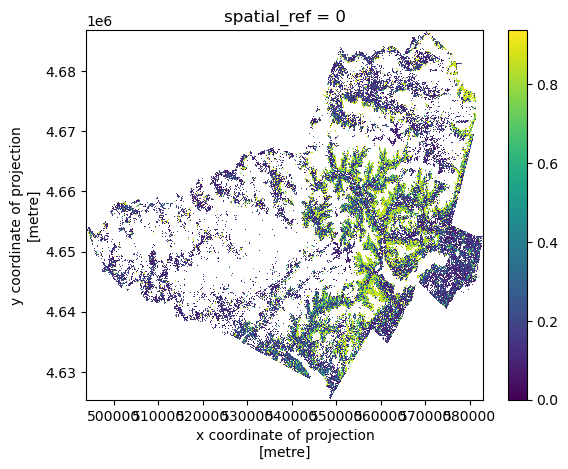

In [49]:
#out_array.to_netcdf(root / 'sentinel_data' / 'catskills' / 'predictions_beforemeangu.nc')

out_array.plot()

In [ ]:



# train bart model

# predict on each version


# mosaic prediction outputs

In [3]:
bart_data = DataStack(root,2019,'bart',26919)
#harv_data = DataStack(root,2018,'harv',26918)
#roi1.plot_input_data(band=3)
#cat_data = DataStack(root,2022,'catskills',26918)

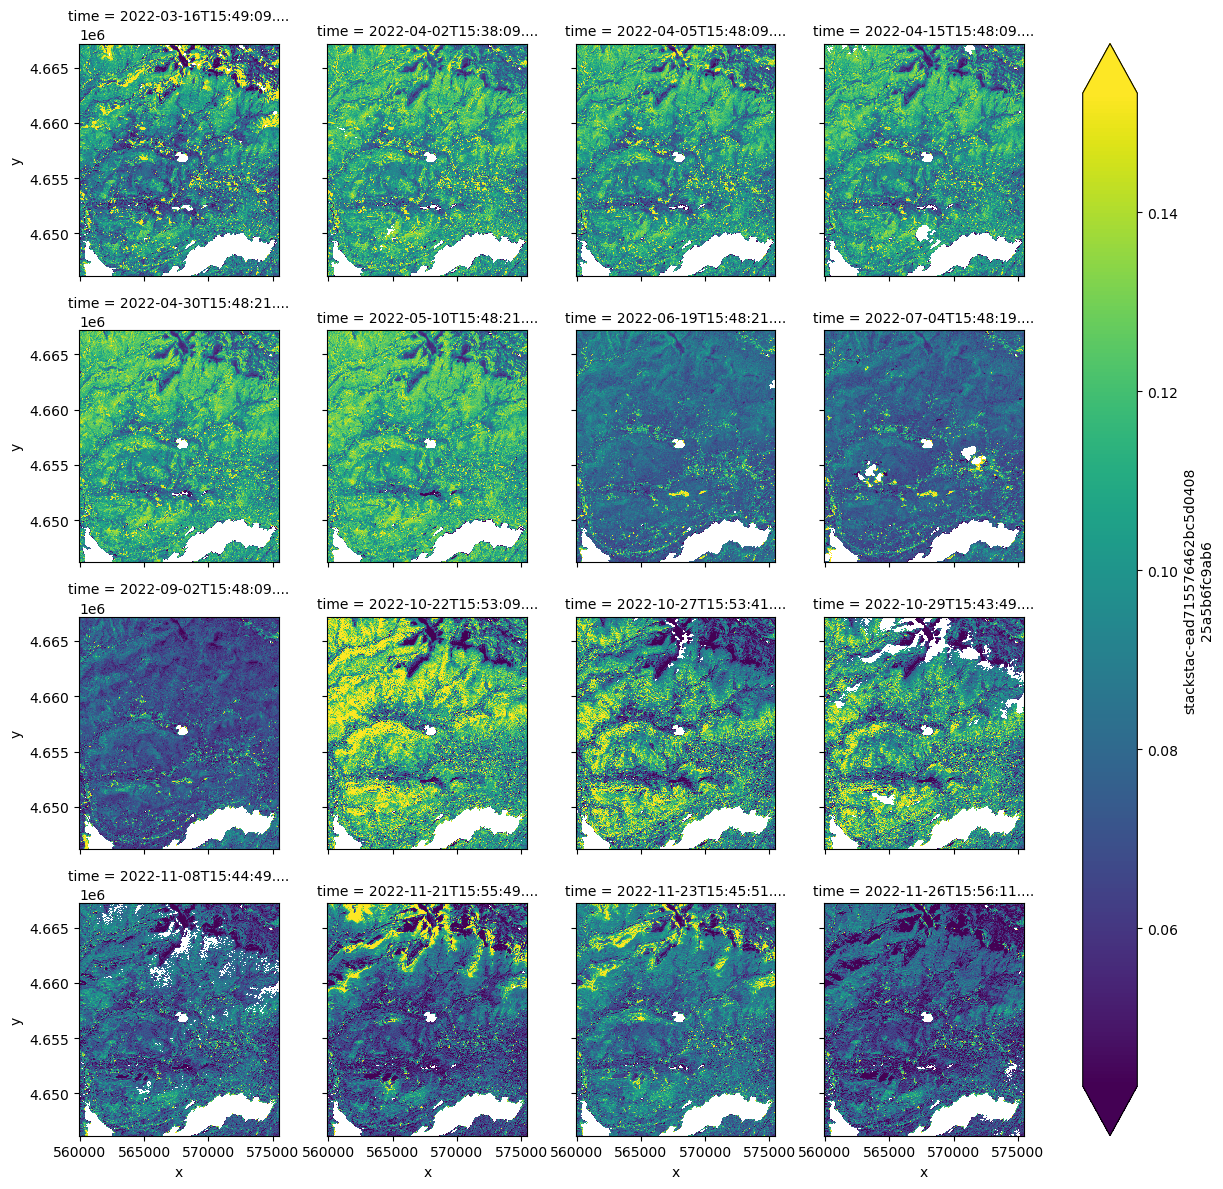

In [ ]:
cat_data.plot_input_data(band=3)  

In [7]:
cat_data.select_season_data(date_list=['04-05','05-10','06-19','07-04','09-02','10-22'])
cat_data.coregister_data()

100%|██████████| 6/6 [1:03:57<00:00, 639.63s/it]


coregisterd bands saves to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree / sentinel_data / catskills / 2022_catskills_aligned_bands.nc


In [4]:
cat_data.add_all_variables(num_months=6,num_of_peak_evi_month=3)

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/catskills/2022_catskills_variables.nc


In [ ]:
# july minus may
cat_data.get_season_differences(first='month3',second='month1',desc='summerminusspring')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/catskills/2022_catskills_diffs_summerminusspring.nc


In [6]:
harv_data.select_season_data(date_list=['05-08','06-17','07-07','08-26','09-05','10-05'])
harv_data.coregister_data() 

100%|██████████| 6/6 [29:50<00:00, 298.44s/it]


coregisterd bands saves to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree / sentinel_data / harv / 2018_harv_aligned_bands.nc


In [7]:
harv_data.add_all_variables(num_months=6,num_of_peak_evi_month=2)

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/harv/2018_harv_variables.nc


In [8]:
harv_data.get_season_differences('month2','month0','summerminusspring')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/harv/2018_harv_diffs_summerminusspring.nc


In [369]:
suny_data = DataStack(root,2018,'suny',26918)
# suny_data.select_season_data(date_list=['05-11','06-30','07-20','08-09','09-13','10-13'])
# suny_data.coregister_data()
# suny_data.plot_season_data(band=3)

In [7]:
suny_data.add_all_variables(num_months=6,num_of_peak_evi_month=2)

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/suny/2018_suny_variables.nc


In [8]:
suny_data.get_season_differences('month2','month5','summerminusfall')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/suny/2018_suny_diffs_summerminusfall.nc


In [ ]:
# manually inspect input data and select the timestamps to keep
bart_data.select_season_data(date_list=['05-08','06-12','07-07','08-26','09-20','10-15'])
bart_data.plot_season_data(band=3)

In [ ]:
bart_data.add_all_variables(num_months=6,num_of_peak_evi_month=2)

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/bartlett/2019_bart_variables.nc


In [259]:
bart_data.get_season_differences('month2','month0','summerminusspring')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/bart/2019_bart_diffs_summerminusspring.nc


In [260]:
suny_data.get_season_differences('month2','month0','summerminusspring')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/suny/2018_suny_diffs_summerminusspring.nc


In [94]:
cat_data.get_season_differences('month3','month5','summerminusfall')

diffs saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/catskills/2022_catskills_diffs_summerminusfall.nc


In [14]:
#['04-05','05-10','06-19','07-04','09-02','10-22']
gs_months=['month1','month2','month3'] # june, july, august
ssf_months=['month0','month2','month5'] # may, july, october

ssf_months_catskills = ['month1','month3','month5']
gs_months_catskills = ['month2','month3','month4']
eos_months_catskills = ['month3','month4','month5']

ssf2_months = ['month0','month2','month4'] # may, july, september

pheno_months = ['month0','month2','month3','month5']

all_months = ['month0','month1','month2','month3','month4','month5']

eos_months = ['month3','month4','month5'] # august,september, october
sos_months = ['month0','month1','month2'] # may, june, july

tc_bands = ['B','evi','bright','green','wet']
nontc_bands = ['B','evi','lswi','slavi','psri']

# nontc pca still has tc vars for differences
# nontc2 uses nontc for differences
p1, p2 = cat_data.run_pca(n=15,monthstouse=ssf_months,bandstouse=nontc_bands,diff_desc=['summerminusspring'],output_desc='ssfcrop2_nontc2_diffspring',save=True)

# p1, p2 = harv_data.run_pca(n=15,monthstouse=ssf_months,bandstouse=nontc_bands,diff_desc=['summerminusspring'],output_desc='ssf_nontc2_diffspring',save=True)

# p1, p2 = bart_data.run_pca(n=15,monthstouse=ssf_months,bandstouse=nontc_bands,diff_desc=['summerminusfall','summerminusspring'],output_desc='ssf_nontc2_diffboth',save=True)

# p1, p2 = suny_data.run_pca(n=15,monthstouse=ssf_months,bandstouse=nontc_bands,diff_desc=['summerminusfall','summerminusspring'],output_desc='ssf_nontc2_diffboth',save=True)

explained variance: [0.33715683 0.56948066 0.72048193 0.79212916 0.8393048  0.88190657
 0.9063468  0.9243055  0.94050854 0.9497387  0.95721805 0.9636433
 0.9686403  0.9729127  0.97654617]
pca saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/catskills/2022_catskills_pca_ssfcrop2_nontc2_diffspring.nc


### Minimum Noise Fraction

In [4]:
class MNF():
    def __init__(self,mnf_image,noise_bbox,noise_cov_matrix,reg_noise_cov_matrix,whitening_matrix,basal_area,labels,root,site_name,epsg):
        self.mnf_image = mnf_image

        self.noise_bbox = noise_bbox
        self.noise_cov_matrix = noise_cov_matrix
        self.reg_noise_cov_matrix = reg_noise_cov_matrix
        self.whitening_matrix = whitening_matrix
        self.basal_area = basal_area
        self.labels = labels
        self.root = root
        self.site_name = site_name
        self.epsg = epsg
        
    
    def plot_noise_region(self):
        bx, by = self.noise_bbox.exterior.xy

        plt.imshow(self.mnf_image[0,:,:])
        plt.fill(bx,by,edgecolor='red',facecolor='red',alpha=0.4)
    
    def check_noise_cov_matrix(self):
        # check stability of noise covariance matrix
        determinant = np.linalg.det(self.noise_cov_matrix) # should be greater than 10e-10
        condition = np.linalg.cond(self.noise_cov_matrix) # should be below 10e7

        eigvals = np.linalg.eigvals(self.noise_cov_matrix)

        print(f'original matrix\ndeterminant: {determinant}\ncondition: {condition}\neigen mean: {np.mean(eigvals)}\neigen variance: {np.var(eigvals)}')

        determinant = np.linalg.det(self.reg_noise_cov_matrix) # should be greater than 10e-10
        condition = np.linalg.cond(self.reg_noise_cov_matrix) # should be below 10e7

        eigvals = np.linalg.eigvals(self.reg_noise_cov_matrix)

        print(f'regularized matrix\ndeterminant: {determinant}\ncondition: {condition}\neigen mean: {np.mean(eigvals)}\neigen variance: {np.var(eigvals)}')

    def check_noise_whitening(self):
        whitened_noise_cov = self.whitening_matrix @ self.reg_noise_cov_matrix @ self.whitening_matrix.T

        plt.imshow(whitened_noise_cov)  # if resembles identity matrix, whitening is applied correctly
    
    def plot_mnf_variance(self):
        # plt.figure(figsize=(12, 6))
        # for i in range(10):  
        #     plt.subplot(2, 5, i + 1)
        #     plt.imshow(self.mnf_image[i,:, :])
        #     plt.title(f"MNF Band {i+1}")
        # plt.show()

        variance = [np.nanvar(self.mnf_image[i,:,:])for i in range(10)]

        plt.plot(np.arange(0,len(variance)),variance)
        plt.show()
        
        
# get noise region based on variance
def get_noise_region_variance(data,percentile):
    
    image = data[0:3,:,:]
    #image = data
    #apply window, calculate variance
    variance_map = np.mean([generic_filter(image[b,:, :], lambda x: np.var(x), size=13) for b in range(image.shape[0])], axis=0)
    # find areas with variance < percentile
    x_2d = rearrange(variance_map,'h w -> (h w)')
    varmap_dropna = x_2d[~np.isnan(x_2d)]   
    threshold = np.percentile(varmap_dropna, percentile)
    low_var = variance_map < threshold
    #extract largest region of low variance
    binary_mask = low_var.astype(np.uint8)

    # Find contours of homogeneous regions
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the largest region
    largest_contour = max(contours, key=cv2.contourArea)
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(largest_contour)

     #box(xmin, ymin, xmax, ymax,
    bx = box(x,y+h,x+w,y)
    
    # Extract the subregion from the image
    return data[:,y:y+h, x:x+w], bx

# get noise region based on otsu thresholding
def get_noise_region_otsu(data): 
    data_array = data.values
    image_rearrange = rearrange(data_array,'c h w -> h w c' )
    image = image_rearrange[:,:,0:3]
    im = np.ma.masked_invalid(image)

    im_norm = im / np.max(im) # normalize the data to 0 - 1
    im_scale = 255 * im_norm # scale by 255
    im_u8 = im_scale.astype(np.uint8) # convert to uint 8
    img = cv2.cvtColor(im_u8, cv2.COLOR_BGR2GRAY) 
    # applying Otsu thresholding 
    # as an extra flag in binary  
    # thresholding      
    ret, low_var = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + 
                                                cv2.THRESH_OTSU) 

    # extract largest region of low variance
    binary_mask = low_var.astype(np.uint8)

    # Find contours of homogeneous regions
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the largest region
    largest_contour = max(contours, key=cv2.contourArea)
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(largest_contour)

     #box(xmin, ymin, xmax, ymax,
    bx = box(x,y+h,x+w,y)
    
    # Extract the subregion from the image
    return data[:,y:y+h, x:x+w], bx

def estimate_noise(image):
    noise = np.zeros_like(image)
    
    # Compute noise for each band
    for b in range(image.shape[0]):
        x_ij = image[b,:, :]
        x_ip1_j = np.roll(x_ij, shift=-1, axis=0)  # Shift left (i+1, j)
        x_i_jp1 = np.roll(x_ij, shift=-1, axis=1)  # Shift up (i, j+1)
        
        # Compute noise 
        noise[b, :, :] = x_ij - 0.5 * (x_ip1_j + x_i_jp1)
    
    return noise

def estimate_noise_gaussian(img):
  
    # Generate Gaussian noise with mean=0, std=0.012 (same shape as image)
    rnoisy = np.random.normal(0, 0.012, size=img.shape)

    # Compute per-channel RMS (Root Mean Square) value
    rms = np.sqrt(np.nanmean(img ** 2, axis=(1, 2), keepdims=True))

    # Scale noise by image RMS 
    noise = rms * rnoisy

    return noise

def get_noise_cov_matrix(noise_matrix):
    
    noise = rearrange(noise_matrix, 'c h w -> (h w) c')

    # remove nans
    noise = noise[~np.isnan(noise).any(axis=1)]  # Remove rows with NaNs
   
    cov = np.cov(noise,rowvar=False)
    
    return cov

def check_matrix(n_cov_matrix):
# check stability of noise covariance matrix
    determinant = np.linalg.det(n_cov_matrix) # should be greater than 10e-10
    condition = np.linalg.cond(n_cov_matrix) # should be below 10e7

    eigvals = np.linalg.eigvals(n_cov_matrix)

    # data_variance = np.nanvar(data, axis=(1,2))  # Variance across spatial dimensions
    # mean_data_variance = np.mean(data_variance)
    # mean_data_variance

    print(f'determinant: {determinant}\ncondition: {condition}\neigen min: {np.min(eigvals)}\neigen max: {np.max(eigvals)}\neigen mean: {np.mean(eigvals)}\neigen variance: {np.var(eigvals)}\neigvals: {eigvals}')

####### adding regularization term gives more numerically resonable output ###########
def regularize_noise(noise_cov_matrix):
    lambda_reg = 1e-1 * np.eye(noise_cov_matrix.shape[0])  # diagonal offset
    reg_cov_matrix = noise_cov_matrix + lambda_reg 

    return reg_cov_matrix


def get_ba_threshold(basal_area):
    r = basal_area.values
    r = r[~np.isnan(r)]

    return round(np.percentile(r,99),3)

def get_endmembers(ba,mnf,ts):  # return pixels with > 99th percentile of basal area
    #thresh = get_ba_threshold(ba)
    h = ba
    #rows, cols = np.where(h>=thresh)
    
   
    if np.nanmax(h.values) < 100:
        thresh = get_ba_threshold(h)
        rows, cols = np.where(h>=thresh)
    else:
        rows, cols = np.where(h==100.0)
    
    pixels = [(int(row),int(col)) for row,col in zip(rows,cols)]
    print(f'found {len(pixels)} pixels where {ts} is {np.nanmax(h.values)} percent basal area')
  

    p_list = []

    for i in range(0,len(pixels)):
        p_list.append(mnf.values[:,pixels[i][0],pixels[i][1]])

    p_array = np.array(p_list) 
    

    p_mean = np.nanmean(p_array,axis=0)

    return p_array, p_mean

def get_endmembers_manual(em, mnf):
    r = em.get_coordinates()   # raster with pre-selected pixels

    v = []
    for i in range(r.shape[0]):
        value = mnf.sel(x=r.iloc[i,0], y=r.iloc[i,1], method="nearest").values
        v.append(value)

    v_mean = np.mean(v,axis=0)

    return v, v_mean
    
def create_mnf_image(datastack,n1,n2,reg=True):
    # takes in DataStack object
    # outputs MNF object with:
        # noise region bbox
        # noise covariance matrix
        # mnf image
        # endmembers in mnf space
    data = datastack.mnf_input.values[n1:n2,:,:]
    

    noise_region, noise_bbox = get_noise_region_variance(data, 30) # first three bands only

    noise = estimate_noise_gaussian(noise_region)
    ############ step 1: whiten data ###########
    n_cov_matrix = get_noise_cov_matrix(noise)
    if reg == True:
        reg_n_cov_matrix = regularize_noise(n_cov_matrix)
        eigvals, eigvecs = np.linalg.eigh(reg_n_cov_matrix)
    else:
        eigvals, eigvecs = np.linalg.eigh(n_cov_matrix)
        reg_n_cov_matrix = None


    # mean correct and reshape the data 
    m = np.nanmean(data, axis=0)
    data = data - m
    reshaped_data = rearrange(data,'b h w -> b (h w)') 

    # Compute the whitening matrix 
    inv_sqrt_eigenvalues = np.diag(1.0 / np.sqrt(eigvals))  # Compute R = Λ^(-1/2)
    whitening_matrix = eigvecs @ inv_sqrt_eigenvalues @ eigvecs.T  \
    # apply whitening transform
    whitened_data = whitening_matrix @ reshaped_data

    ####### step 2: PCA rotation #######
    # drop nas before applying pca
    whitened_data = rearrange(whitened_data,'c r -> r c')
    dropna = whitened_data[~np.isnan(whitened_data).any(axis=1)]
    # get indices of dropped nas to replace them later
    na_indices = np.where(np.isnan(whitened_data))
    row_indices = np.unique(na_indices[0]) # indices of rows that were dropped 

    # pca on whitened data; needs to be in form (rows, columns)
    pca = PCA()
    mnf = pca.fit_transform(dropna)

    # replace nans that were dropped earlier
    output_array = np.full((whitened_data.shape[0],mnf.shape[1]), np.nan)  # create array of correct shape
    non_nan_indices = np.setdiff1d(np.arange(whitened_data.shape[0]), row_indices) 
    output_array[non_nan_indices] = mnf

    # Reshape back to image format
    mnf_image = rearrange(output_array,'(h w) b -> b h w',h=data.shape[1],w=data.shape[2])


    # convert to xarray with geographic coodinates
    band_names = [f'comp_{x}' for x in range(mnf_image.shape[0])]
    mnf_image = xr.DataArray(mnf_image, coords={'band': band_names,'y': datastack.y_coords, 'x': datastack.x_coords},dims=['band','y','x'])
    
    ########### get endmembers ###############
    # if em_manual == True:
    #     endmember_array, endmember_mean = get_endmembers_manual(datastack.endmember_manual, mnf=mnf_image)
    # else:
    #     endmember_array, endmember_mean = get_endmembers(datastack.basal_area, mnf_image)

    return MNF(mnf_image = mnf_image,noise_bbox=noise_bbox, noise_cov_matrix=n_cov_matrix, reg_noise_cov_matrix=reg_n_cov_matrix,whitening_matrix=whitening_matrix,basal_area=datastack.basal_area,labels=datastack.labels,root=datastack.root,site_name=datastack.site_name,epsg=datastack.epsg)





# get cov matrix of mnf, find how many eigenvalues are > threshold, select that number of components from mnf image
def get_num_high_signal_components(mnf_image,thresh):
    mnf_2d = rearrange(mnf_image, 'c h w -> (h w) c')
    mnf_dropna = mnf_2d[~np.isnan(mnf_2d).any(axis=1)]  # Remove rows with NaNs
    mnf_cov = np.cov(mnf_dropna,rowvar=False)
    mnf_eigvals, _ = np.linalg.eigh(mnf_cov)
    return len(mnf_eigvals[mnf_eigvals>=thresh]), mnf_eigvals

def make_2d_input_data(data):
    x_2d = rearrange(data,'c h w -> (h w) c')
    x_dropna = x_2d[~np.isnan(x_2d).any(axis=1)]  # Remove rows with NaNs
    
    # get indices of dropped nas to replace them later
    na_indices = np.where(np.isnan(x_2d))
    row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

    return x_2d, x_dropna, row_indices

def replace_na_and_reshape(data_2d,final_data,indices,shape):
# replace nans that were dropped earlier
    output = np.full((data_2d.shape[0]), np.nan)  # create array of correct shape

    # Fill in the rows that were not NaN
    non_nan_indices = np.setdiff1d(np.arange(data_2d.shape[0]), indices)  # get indices that don't have na values
    output[non_nan_indices] = final_data

    r = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()
    return r
    


def mixture_tuned_matched_filter(mnf_object,SNR,mean=True,array_num=0,target_species='beech',catskills=False):
    # takes in MNF object
    # outputs array with MF score, IF score, and basal area bands

    # add get endmembers here
    # mnf_object.basal_area[f'{target_species}_basal_area']
    endmember_array, endmember_mean = get_endmembers(mnf_object.basal_area[f'{target_species}_basal_area'], mnf_object.mnf_image,ts=target_species)


    ###### select MNF components to use###########
    t = SNR # threshold for eigenvalues
    n, eigvals = get_num_high_signal_components(mnf_object.mnf_image.values,t)
    mnf = mnf_object.mnf_image.values[:n,:,:]
    print(f'{n} MNF components used with eigvals between {np.min(eigvals[eigvals>=t])} and {np.max(eigvals[eigvals>=t])}')

    # Target spectral signature 
    if mean == True:
        #target = mnf_object.em_mean[:n]
        target = endmember_mean[:n]
    else:
        #target = mnf_object.em_array[array_num][:n]
        target = endmember_array[array_num][:n]
    # background mean 
    #u_b = np.nanmean(mnf, axis=(1, 2))  
    # difference between target and background mean - not present in Mundt
    #d_tb = (target- u_b)
    ############ matched filter ######################
    # Calculate the covariance matrix of the background
    mnf_2d, mnf_dropna, na_indices = make_2d_input_data(mnf) 
    C = np.cov(mnf_dropna, rowvar=False)  

    det = np.linalg.det(C) # should be greater than 10e-10
    cond = np.linalg.cond(C) # should be below 10e7
    print(f'mnf covariance matrix:\n  determinant: {det}\n  condition: {cond}')
    C1 = np.linalg.inv(C)
    #epsilon = 1e-6  # Small regularization term
    #C1 = np.linalg.inv(C + epsilon * np.eye(C.shape[0]))

    # Normalization coefficient 
    coef = 1.0 / target @ C1 @ target
    
    A = (coef * target) @ C1 # transformation matrix
    Y = (A @ mnf_dropna.T).T

    matched_filter = replace_na_and_reshape(mnf_2d,Y,na_indices,mnf.shape)

    print(f'MF max: {np.nanmax(matched_filter)}, MF min: {np.nanmin(matched_filter)}, MF mean: {np.nanmean(matched_filter)}')

    

    ######## infeasibility score #################

    # Compute target vector component 
    target_component = matched_filter[..., np.newaxis] * target  # Shape: (H, W, D)
    target_component = rearrange(target_component,'h w d -> d h w')

    eigvals, _ = np.linalg.eigh(C) # C = covariance matrix of mnf image
    # Compute interpolated eigenvalues; scale mnf eigenvalues based on the MF scores
    noise = np.ones((n,))  # size corresponds to number of components; noise has unit variance

    sqrt_eig = np.sqrt(eigvals)  
    interp_eig = (sqrt_eig - matched_filter[..., np.newaxis] * (sqrt_eig - noise))**2  

    interp_eig = np.where(interp_eig == 0, 1e-6, interp_eig)  # Avoid divide-by-zero issues
    interp_eig = rearrange(interp_eig,'h w d -> d h w')

    r = mnf - target_component
    r_2d, r_dropna, r_indices = make_2d_input_data(r)

    r_norm = np.linalg.norm(np.nan_to_num(r_dropna),axis=1)
    r2 = replace_na_and_reshape(r_2d,r_norm,r_indices,mnf.shape)

    e_2d, e_dropna, e_indices = make_2d_input_data(interp_eig)

    s = np.linalg.norm(np.nan_to_num(e_dropna,nan=1e-6),axis=1)
    s2 = replace_na_and_reshape(e_2d,s,e_indices,mnf.shape)

    infeas_score = r2/s2

    print(f'infeas max: {np.nanmax(infeas_score)}, infeas min: {np.nanmin(infeas_score)}, infeas mean: {np.nanmean(infeas_score)}')

    matched_filter = xr.DataArray(matched_filter, coords={'y': mnf_object.mnf_image.y.values, 'x': mnf_object.mnf_image.x.values},dims=['y','x'])

    infeas_score = xr.DataArray(infeas_score, coords={'y': mnf_object.mnf_image.y.values, 'x': mnf_object.mnf_image.x.values},dims=['y','x'])

    if catskills == True:
        beech_category = xr.where(mnf_object.basal_area['beech_basal_area'] == 100, 1.0, 
                        xr.where(mnf_object.basal_area['beech_basal_area'] == 0, 0.0, 2.0))

        # Add to dataset
        mnf_object.basal_area['beech_category'] = beech_category
      
    q = xr.concat([matched_filter,infeas_score,mnf_object.basal_area[f'{target_species}_basal_area'],mnf_object.basal_area[f'{target_species}_category']],dim='band')
    q = q.assign_coords({'band':[f'{target_species}_mf_score',f'{target_species}_infeas_score',f'{target_species}_basal_area',f'{target_species}_categories']})
    
    return MTMF(array=q,target=target,target_species=target_species,labels=mnf_object.labels,root=mnf_object.root,site_name=mnf_object.site_name,epsg=mnf_object.epsg)



class MTMF():
    def __init__(self,array,target,target_species,labels,root,site_name,epsg):
        self.result_array = array
        self.target = target
        self.matched_filter = self.result_array.sel(band=f'{target_species}_mf_score').values
        self.infeas_score = self.result_array.sel(band=f'{target_species}_infeas_score').values
        self.basal_area = self.result_array.sel(band=f'{target_species}_basal_area').values
        self.categories = self.result_array.sel(band=f'{target_species}_categories').values
        self.labels = labels
        self.target_species = target_species
        self.root = root
        self.site_name = site_name
        self.epsg = epsg


    def plot_histograms(self):
        fig, ax = plt.subplots(1, 2, figsize=(8,4))

        ax[0].hist(self.matched_filter.flatten(), bins=50)
        ax[0].set_title("Matched Filter")

        ax[1].hist(self.infeas_score.flatten(), bins=50)
        ax[1].set_title("Infeasibility")

        plt.tight_layout()
        plt.show()

    def plot_correlation(self,catskills=False):
        
        # i_2d = rearrange(self.infeas_score,'h w -> (h w)')
        # ba_2d = rearrange(self.basal_area,'h w -> (h w)')
        # t2_2d = rearrange(self.matched_filter,'h w -> (h w)')
        # c_2d = rearrange(self.categories,'h w -> (h w)' )

        # combine = np.vstack((ba_2d,t2_2d,i_2d,c_2d)).T

        # combine = combine[~np.isnan(combine).any(axis=1)]

        # df = pd.DataFrame(combine)
        # df.columns = ['basal_area','mf_score','infeas_score','category']

        df = pd.DataFrame(rearrange(self.result_array.values,'b h w -> (h w) b'),columns=self.result_array.band.values)
        df = df[~np.isnan(df).any(axis=1)]
        df.columns = ['_'.join(x.split('_')[1:]) for x in self.result_array.band.values]

        if catskills == True:
            g = sns.scatterplot(data=df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'))
        else:
            # read in category labels for target species
            label_df = pd.read_csv([x for x in self.labels if self.target_species in x][0])

            # make dictionary to make sure labels are properly matched to categories
            label_dict = {}
            for i in range(len(label_df)):
                    label_dict[str(i)+'.0'] = label_df.loc[i,'cat_labels']


            g = sns.scatterplot(data=df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'))
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles=handles,labels=[label_dict.get(x) for x in labels])
            sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    def plot_threshold(self,mf_greaterthan,infeas_lessthan,save=False,epsg=None):
        mask_1 = self.result_array.sel(band='mf_score')>mf_greaterthan
        mask_2 = self.result_array.sel(band='infeas_score')<infeas_lessthan

        threshold = self.result_array.where(mask_1 & mask_2)
        threshold.sel(band='mf_score').plot() 
        
        if save == True:
            threshold = threshold.rio.write_crs(epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
            threshold.sel(band='mf_score').to_netcdf(self.root / 'output' / self.site_name.upper() / f'{self.target_species}_mtmf_result.nc')

        

        
        

    
    


    

found 15 pixels where beech is 100.0 percent basal area


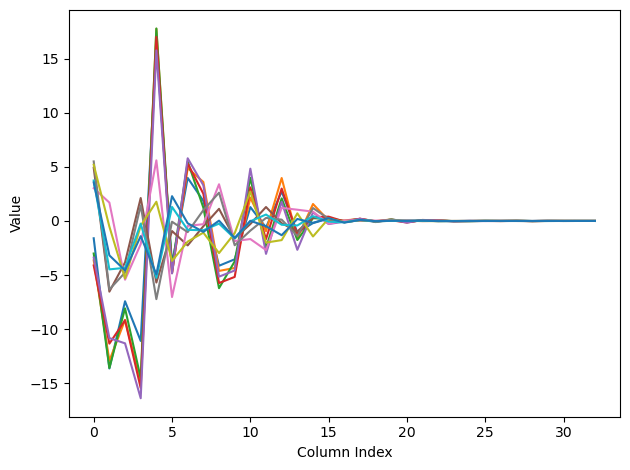

In [ ]:
def get_endmembers(ba,mnf,ts):  # return pixels with > 99th percentile of basal area
    #thresh = get_ba_threshold(ba)
    h = ba
    #rows, cols = np.where(h>=thresh)
    
   
    if np.nanmax(h.values) < 100:
        thresh = get_ba_threshold(h)
        rows, cols = np.where(h>=thresh)
    else:
        rows, cols = np.where(h==100.0)
    
    pixels = [(int(row),int(col)) for row,col in zip(rows,cols)]
    print(f'found {len(pixels)} pixels where {ts} is {np.nanmax(h.values)} percent basal area')
  

    p_list = []

    for i in range(0,len(pixels)):
        p_list.append(mnf.values[:,pixels[i][0],pixels[i][1]])

    p_array = np.array(p_list) 
    

    p_mean = np.nanmean(p_array,axis=0)

    return p_array, p_mean, pixels

p_array, p_mean, pixels = get_endmembers(cat_data.basal_area['beech_basal_area'],cat_mnf.mnf_image,ts='beech')
for row in p_array[0:11]:
    plt.plot(row)

plt.xlabel('Column Index')
plt.ylabel('Value')
plt.tight_layout()
plt.show()




# for row in e_array.T:
#     plt.plot(row)
# n_rows = e_array.shape[0]

# fig, axes = plt.subplots(n_rows, 1, figsize=(8, 2 * n_rows), sharex=True)

# # If only 1 row, axes is not an array
# if n_rows == 1:
#     axes = [axes]

# for i, ax in enumerate(axes):
#     row = e_array[i]
#     valid = np.isfinite(row)
#     ax.plot(np.arange(len(row))[valid], row[valid])
#     ax.set_ylabel(f'Row {i}')
#     ax.grid(True)

# axes[-1].set_xlabel('Column Index')

# plt.tight_layout()
# plt.show()

In [5]:
# output = MnfInput object (stack of bands to use to calculate mnf)
# months = which months bands to include
# v1, v2 = which version of pca to use
# diff_desc = which difference to use (e.g. 'summerminusfall')
#cat_data.make_mnf_input(v1='ssfcrop2',v2='nontc2_diffspring',month=['month3'],diff_desc=['summerminusspring'])
#gs_tc_mnf_input = roi1.make_mnf_input(v1='gs',v2='tc',month='month2',diffs=True,diff_num=0)
bart_data.make_mnf_input(v1='ssf',v2='nontc2_diffspring',month=['month2'],diff_desc=['summerminusspring'])
#ssf_tc_mnf_input = roi1.make_mnf_input(v1='ssf',v2='tc',month='month2',diffs=True,diff_num=0)
#harv_data.make_mnf_input(v1='ssf',v2='nontc2_diffspring',month=['month2'],diff_desc=['summerminusspring'])
#suny_data.make_mnf_input(v1='ssf',v2='nontc2_diffboth',month=['month2'],diff_desc=['summerminusspring'])

In [6]:
n1 =0
n2 = 33
#suny_mnf = create_mnf_image(suny_data,n1=n1,n2=n2,reg=True)
#cat_mnf = create_mnf_image(cat_data,n1=n1,n2=n2,reg=True)
bart_mnf = create_mnf_image(bart_data,n1=n1,n2=n2,reg=True)
#harv_mnf = create_mnf_image(harv_data,n1=n1,n2=n2,reg=True)

C:\Users\roseh\AppData\Local\Temp\ipykernel_7204\2692845233.py:247: RuntimeWarning: Mean of empty slice
  m = np.nanmean(data, axis=0)


In [17]:
cat_mtmf = mixture_tuned_matched_filter(cat_mnf,SNR=50,mean=True,array_num=14,target_species='beech',catskills=True)

found 6 pixels where beech is 100.0 percent basal area
3 MNF components used with eigvals between 67.32277511543141 and 152.8210747273533
mnf covariance matrix:
  determinant: 1179427.3584356948
  condition: 2.269975865750137
MF max: 1.1412415137292093, MF min: -0.23154031253706048, MF mean: -2.2938557384419598e-17
infeas max: 811.8942822808766, infeas min: 0.0009167439547288395, infeas mean: 0.07932728418889952


C:\Users\roseh\AppData\Local\Temp\ipykernel_19104\2692845233.py:470: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  g = sns.scatterplot(data=df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'))


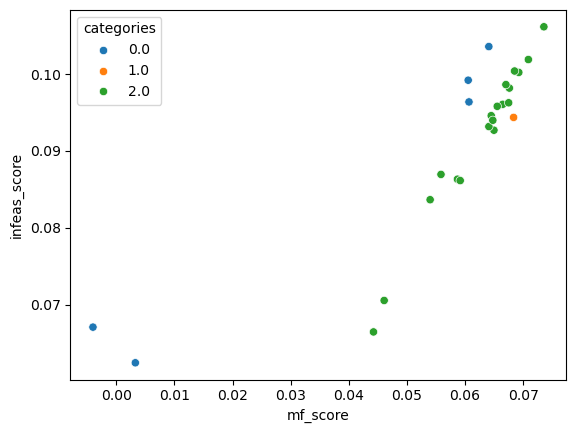

In [18]:
cat_mtmf.plot_correlation(catskills=True)

In [ ]:
suny_mtmf = mixture_tuned_matched_filter(suny_mnf,SNR=15,mean=True,array_num=0,target_species='beech')

In [ ]:
suny_mtmf.plot_correlation()

In [56]:
harv_mtmf = mixture_tuned_matched_filter(harv_mnf,SNR=30,mean=True,array_num=0,target_species='birch')

found 1 pixels where birch is 100.0 percent basal area
4 MNF components used with eigvals between 38.7296919301706 and 150.27504126030198
mnf covariance matrix:
  determinant: 30847521.40848197
  condition: 3.8800990602054637
MF max: 0.9665360250611215, MF min: -0.5653248140096497, MF mean: 2.6983120987445976e-16
infeas max: 29.22754080627153, infeas min: 0.0016209810761713026, infeas mean: 0.08850741842894702


C:\Users\roseh\AppData\Local\Temp\ipykernel_15308\1125212402.py:470: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  g = sns.scatterplot(data=df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'))


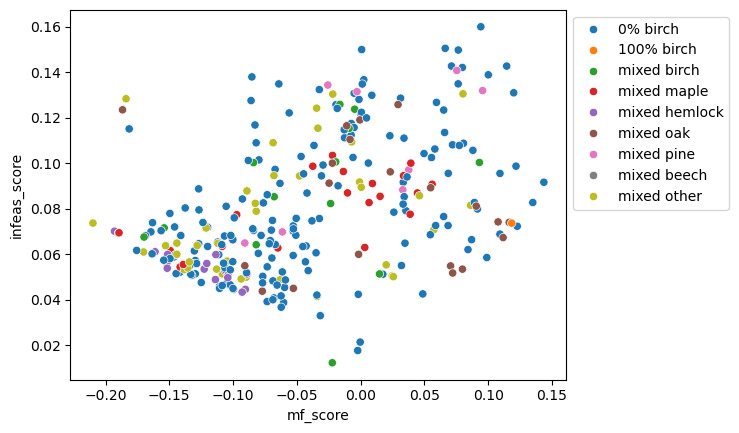

In [57]:
harv_mtmf.plot_correlation()

In [7]:
bart_mtmf = mixture_tuned_matched_filter(bart_mnf,SNR=29,mean=True,array_num=0,target_species='beech')

found 16 pixels where beech is 100.0 percent basal area
3 MNF components used with eigvals between 39.911541195045345 and 221.7278350674654
mnf covariance matrix:
  determinant: 606617.8899284964
  condition: 5.55548165839787
MF max: 0.5841100443555453, MF min: -0.16490066875171716, MF mean: -1.5226479464351654e-17
infeas max: 3.0425304115571903, infeas min: 0.0007677393446361537, infeas mean: 0.0672103919798661


C:\Users\roseh\AppData\Local\Temp\ipykernel_7204\2692845233.py:481: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  g = sns.scatterplot(data=df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'))


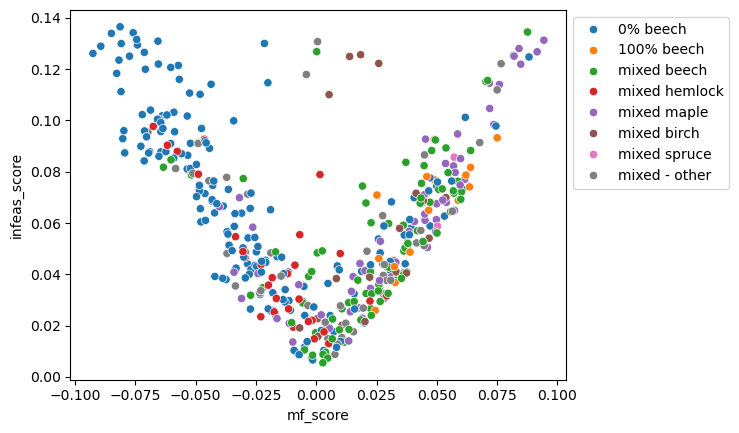

In [8]:
bart_mtmf.plot_correlation()

In [10]:
bart_mtmf.result_array.to_netcdf(root / 'output' / 'BART' / 'bart_mtmf_result_array.nc')

### Regression/Classification

In [ ]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import json
import folium
import io
import base64
import branca.colormap as cm

# functions to align target site mtmf output with training site mtmf output

# def make_df(mtmf_obj):
#         df = pd.DataFrame(rearrange(mtmf_obj.result_array.values,'b h w -> (h w) b'),columns=mtmf_obj.result_array.band.values)
#         df = df[~np.isnan(df).any(axis=1)]
#         df.columns = ['_'.join(x.split('_')[1:]) for x in mtmf_obj.result_array.band.values]
#         return df

# def scale_approach(df1,df2):
        
#         scaler_mf = MinMaxScaler().fit(df1[['mf_score']])
#         scaler_if = MinMaxScaler().fit(df1[['infeas_score']])

#         # Transform both datasets using the same parameters
#         transformed_mf = scaler_mf.transform(df2[['mf_score']])
#         transformed_if = scaler_if.transform(df2[['infeas_score']])

#         df2_copy = df2.copy()
#         df2_copy['mf_score'] = transformed_mf.flatten()  # Convert 2D array to 1D
#         df2_copy['infeas_score'] = transformed_if.flatten() 

#         transformed_mf = scaler_mf.transform(df1[['mf_score']])
#         transformed_if = scaler_if.transform(df1[['infeas_score']])

#         df1_copy = df1.copy()
#         df1_copy['mf_score'] = transformed_mf.flatten()  # Convert 2D array to 1D
#         df1_copy['infeas_score'] = transformed_if.flatten() 

#         return df1_copy,df2_copy

# def shift_approach(df1, df2):
   
#     # Extract beech points (assuming categories identify beech points)
#     beech_mask_A = df1['categories'] == 1.0  
#     beech_mask_B = df2['categories'] == 1.0  
    
#     # Calculate means for beech and non-beech points in both datasets
#     beech_mean_A = df1[beech_mask_A][['mf_score', 'infeas_score']].mean()
#     beech_mean_B = df2[beech_mask_B][['mf_score', 'infeas_score']].mean()
    
#     # Calculate the shift needed to align beech points
#     shift_mf = beech_mean_A['mf_score'] - beech_mean_B['mf_score']
#     shift_infeas = beech_mean_A['infeas_score'] - beech_mean_B['infeas_score']
    
#     # Create a copy of df2 with scaled columns
#     df2_aligned = df2.copy()
#     df2_aligned['mf_score_scaled'] = df2['mf_score'] + shift_mf
#     df2_aligned['infeas_score_scaled'] = df2['infeas_score'] + shift_infeas
    
#     return df2_aligned

# def shift_approach2(df1, df2):
#     """
#     Aligns dataset B (df2) with dataset A (df1) focusing on both 0% and 100% beech.
#     """
#     # Extract beech and non-beech points
#     beech_mask_A = df1['categories'] == 1.0  # 100% beech category
#     nonbeech_mask_A = df1['categories'] == 0.0  # 0% beech category
    
#     beech_mask_B = df2['categories'] == 1.0
#     nonbeech_mask_B = df2['categories'] == 0.0
    
#     # Calculate centroids for both categories in both datasets
#     beech_mean_A = df1[beech_mask_A][['mf_score', 'infeas_score']].mean()
#     nonbeech_mean_A = df1[nonbeech_mask_A][['mf_score', 'infeas_score']].mean()
    
#     beech_mean_B = df2[beech_mask_B][['mf_score', 'infeas_score']].mean()
#     nonbeech_mean_B = df2[nonbeech_mask_B][['mf_score', 'infeas_score']].mean()
    
#     # Use the average shift between both categories
#     shift_mf = ((beech_mean_A['mf_score'] - beech_mean_B['mf_score']) + 
#                 (nonbeech_mean_A['mf_score'] - nonbeech_mean_B['mf_score'])) / 2
                
#     shift_infeas = ((beech_mean_A['infeas_score'] - beech_mean_B['infeas_score']) + 
#                    (nonbeech_mean_A['infeas_score'] - nonbeech_mean_B['infeas_score'])) / 2
    
#     # Apply the shift
#     df2_aligned = df2.copy()
#     df2_aligned['mf_score_scaled'] = df2['mf_score'] + shift_mf
#     df2_aligned['infeas_score_scaled'] = df2['infeas_score'] + shift_infeas
    
#     return df2_aligned

# def scale_and_shift_approach(df1,df2):

#     df1_scale, df2_scale = scale_approach(df1,df2)

#     df2_shift = shift_approach(df1_scale,df2_scale)

#     return df1_scale,df2_shift

# def make_plot(mtmf_obj1,mtmf_obj2,scale):
#         df1 = make_df(mtmf_obj1)
#         df2 = make_df(mtmf_obj2)

#         if scale == True:
#                 df1,df2 = scale_and_shift_approach(df1,df2)
#         else:
#                 df2 = shift_approach(df1,df2)  # shift mean of beech points

#         # read in category labels for target species
#         label_df1 = pd.read_csv([x for x in mtmf_obj1.labels if mtmf_obj1.target_species in x][0])
#         # make dictionary to make sure labels are properly matched to categories
#         label_dict1 = {}
#         for i in range(len(label_df1)):
#                 label_dict1[str(i)+'.0'] = label_df1.loc[i,'cat_labels']

#         # read in category labels for target species
#         label_df2 = pd.read_csv([x for x in mtmf_obj2.labels if mtmf_obj2.target_species in x][0])
#         # make dictionary to make sure labels are properly matched to categories
#         label_dict2 = {}
#         for i in range(len(label_df2)):
#                 label_dict2[str(i)+'.0'] = label_df2.loc[i,'cat_labels']

#         fig, axes = plt.subplots(1, 3, figsize=(20, 5))  #  row,  columns    
#         axes = axes.ravel()   

#         g = sns.scatterplot(data=df1, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'),ax=axes[0])
#         handles, labels = g.get_legend_handles_labels()
#         g.legend(handles=handles,labels=[label_dict1.get(x) for x in labels])
#         g.set_title('Bartlett Data')
#         sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

#         g = sns.scatterplot(data=df2, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10'),ax=axes[1])
#         handles, labels = g.get_legend_handles_labels()
#         g.legend(handles=handles,labels=[label_dict1.get(x) for x in labels])
#         g.set_title('Site Data')
#         sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

#         g = sns.scatterplot(data=df2, x='mf_score_scaled', y='infeas_score_scaled', hue='categories',palette=sns.color_palette('tab10'),ax=axes[2])
#         handles, labels = g.get_legend_handles_labels()
#         g.set_title('Site Data Scaled')
#         g.legend(handles=handles,labels=[label_dict1.get(x) for x in labels])
#         sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

#         plt.tight_layout()
#         plt.show()


# make_plot(mtmf_obj1=bart_mtmf,mtmf_obj2=suny_mtmf,scale=True)
# make_plot(mtmf_obj1=bart_mtmf,mtmf_obj2=suny_mtmf,scale=False)

class ModelDeployer():
    def __init__(self,train_data_obj,target_data_obj,target_species,type='clf'):
        self.root = train_data_obj.root
        self.train_site_name = train_data_obj.site_name
        self.target_site_name = target_data_obj.site_name
        self.target_epsg = target_data_obj.epsg
        self.train_epsg = train_data_obj.epsg
        self.train_data_array = train_data_obj.result_array
        self.target_data_array = target_data_obj.result_array
        self.target_species = target_species
        self.train_site_labels = train_data_obj.labels
        self.target_site_labels = target_data_obj.labels

        self.train_site_df = self.make_df(type='train_site')
        self.target_site_df = self.make_df(type='target_site')
        self.target_site_shifted_df, _, _ = self.translation_transform(self.train_site_df,self.target_site_df)

        self.ind_vars = [x for x in self.train_site_df.columns if any(y in x for y in ['mf_score','infeas_score'])]
        self.X = self.train_site_df.loc[:,self.ind_vars].values
        if type == 'clf':
            self.y = self.train_site_df.loc[:,'binary'].values
        else:
            self.y = self.train_site_df.loc[:,'basal_area'].values

        f1 = self.root / 'output' / self.train_site_name.upper() / 'param_dicts.json'   
        if os.path.isfile(f1):
            param_dict = json.load( open( f1) )  # load saved parameters if file exists
            self.clf_mlp_params = param_dict['clf_mlp_params']
            self.clf_xg_params = param_dict['clf_xg_params']
            self.clf_gbm_params = param_dict['clf_gbm_params']
            self.clf_rf_params = param_dict['clf_rf_params']
            self.reg_mlp_params = param_dict['reg_mlp_params']
            self.reg_xg_params = param_dict['reg_xg_params']
            self.reg_gbm_params = param_dict['reg_gbm_params']
            self.reg_rf_params = param_dict['reg_rf_params']
       
            # model objects initialized with optimized parameters from saved param dictionaries
        
            self.clf_mlp = MLPClassifier(hidden_layer_sizes=self.clf_mlp_params['hidden_layer_sizes'],max_fun=self.clf_mlp_params['max_fun'],max_iter=self.clf_mlp_params['max_iter'],activation=self.clf_mlp_params['activation'],solver=self.clf_mlp_params['solver'],alpha=self.clf_mlp_params['alpha'])

            
            self.clf_xgboost = xgb.XGBClassifier(objective='binary:logistic',gamma=self.clf_xg_params['gamma'],learning_rate=self.clf_xg_params['learning_rate'],max_depth=self.clf_xg_params['max_depth'],n_estimators=self.clf_xg_params['n_estimators'],reg_lambda=self.clf_xg_params['reg_lambda'])

            self.clf_gbm = GradientBoostingClassifier(ccp_alpha=self.clf_gbm_params['ccp_alpha'],learning_rate=self.clf_gbm_params['learning_rate'],max_depth=self.clf_gbm_params['max_depth'],n_estimators=self.clf_gbm_params['n_estimators'],n_iter_no_change=self.clf_gbm_params['n_iter_no_change'],subsample=self.clf_gbm_params['subsample'],validation_fraction=self.clf_gbm_params['validation_fraction'])

            self.clf_rf = RandomForestClassifier(class_weight='balanced',ccp_alpha=self.clf_rf_params['ccp_alpha'],n_estimators=self.clf_rf_params['n_estimators'],criterion=self.clf_rf_params['criterion'],max_samples=self.clf_rf_params['max_samples'],min_samples_leaf=self.clf_rf_params['min_samples_leaf'],min_samples_split=self.clf_rf_params['min_samples_split'])
            

            self.reg_mlp = MLPRegressor(hidden_layer_sizes=self.clf_mlp_params['hidden_layer_sizes'],max_fun=self.clf_mlp_params['max_fun'],max_iter=self.clf_mlp_params['max_iter'],activation=self.clf_mlp_params['activation'],solver=self.clf_mlp_params['solver'],alpha=self.clf_mlp_params['alpha'])

            self.reg_xgboost = xgb.XGBRegressor(objective='binary:logistic',gamma=self.clf_xg_params['gamma'],learning_rate=self.clf_xg_params['learning_rate'],max_depth=self.clf_xg_params['max_depth'],n_estimators=self.clf_xg_params['n_estimators'],reg_lambda=self.clf_xg_params['reg_lambda'])

            self.reg_gbm = GradientBoostingRegressor(ccp_alpha=self.clf_gbm_params['ccp_alpha'],learning_rate=self.clf_gbm_params['learning_rate'],max_depth=self.clf_gbm_params['max_depth'],n_estimators=self.clf_gbm_params['n_estimators'],n_iter_no_change=self.clf_gbm_params['n_iter_no_change'],subsample=self.clf_gbm_params['subsample'],validation_fraction=self.clf_gbm_params['validation_fraction'])

            self.reg_rf = RandomForestRegressor(ccp_alpha=self.clf_rf_params['ccp_alpha'],n_estimators=self.clf_rf_params['n_estimators'],criterion=self.clf_rf_params['criterion'],max_samples=self.clf_rf_params['max_samples'],min_samples_leaf=self.clf_rf_params['min_samples_leaf'],min_samples_split=self.clf_rf_params['min_samples_split'])

            # calibrated versions of tuned clf models
            self.clf_mlp_cal = CalibratedClassifierCV(self.clf_mlp,cv=5,method='isotonic')
            self.clf_xgboost_cal = CalibratedClassifierCV(self.clf_xgboost,cv=5,method='isotonic')
            self.clf_gbm_cal = CalibratedClassifierCV(self.clf_gbm,cv=5,method='isotonic')
            self.clf_rf_cal = CalibratedClassifierCV(self.clf_rf,cv=5,method='isotonic')

            ### add reg models

            self.prediction = None

        else:
            print('optimized parameter dicitonary does not exist. need to train models with ModelBuilder()')

    def make_df(self,type):
        
        if type == 'train_site':
            m = self.train_data_array
        else:
            m = self.target_data_array

        out_df = pd.DataFrame(rearrange(m.values,'b h w -> (h w) b'),columns=m.band.values)
        out_df = out_df[~np.isnan(out_df).any(axis=1)]
        out_df.columns = ['_'.join(x.split('_')[1:]) for x in m.band.values]

        conditions_binary = [(out_df['basal_area']==0.0),
                    out_df[f'basal_area']>0.0
                    ]
        binary_cats = [0,1]
        out_df['binary'] = np.select(conditions_binary,binary_cats, default=0)
        
        return out_df
    
    def translation_transform(self,df1, df2):
        # shift target data based on 100% beech points in train site data
        # Extract beech points only
        beech_mask_A = df1['categories'] == 1.0  
        beech_mask_B = df2['categories'] == 1.0  
        if 1.0 in df2['categories']:
            beech_mask_B = df2['categories'] == 1.0 
        else:
            beech_mask_B = df2['basal_area']>0
        
        # Calculate means 
        beech_mean_A = df1[beech_mask_A][['mf_score', 'infeas_score']].mean()
        beech_mean_B = df2[beech_mask_B][['mf_score', 'infeas_score']].mean()
        
        # Calculate the difference in means
        shift_mf = beech_mean_A['mf_score'] - beech_mean_B['mf_score']
        shift_infeas = beech_mean_A['infeas_score'] - beech_mean_B['infeas_score']
        
        # Create a copy of df2 with scaled columns
        df2_aligned = df2.copy()
        df2_aligned['mf_score'] = df2['mf_score'] + shift_mf
        df2_aligned['infeas_score'] = df2['infeas_score'] + shift_infeas
        
        return df2_aligned, shift_mf, shift_infeas
        
    def plot_input_data(self):
            # read in category labels for target species
            label_df1 = pd.read_csv([x for x in self.train_site_labels if self.target_species in x][0])
            # make dictionary to make sure labels are properly matched to categories
            label_dict1 = {}
            for i in range(len(label_df1)):
                    label_dict1[str(i)+'.0'] = label_df1.loc[i,'cat_labels']

            # read in category labels for target species
            label_df2 = pd.read_csv([x for x in self.target_site_labels if self.target_species in x][0])
            # make dictionary to make sure labels are properly matched to categories
            label_dict2 = {}
            for i in range(len(label_df2)):
                    label_dict2[str(i)+'.0'] = label_df2.loc[i,'cat_labels']

            # get xlims
            all_x_values = pd.concat([
            self.train_site_df['mf_score'],
            self.target_site_df['mf_score'],
            self.target_site_shifted_df['mf_score']
        ])
            x_min, x_max = all_x_values.min(), all_x_values.max()

            all_y_values = pd.concat([
            self.train_site_df['infeas_score'],
            self.target_site_df['infeas_score'],
            self.target_site_shifted_df['infeas_score']
        ])
            y_min, y_max = all_y_values.min(), all_y_values.max()

            fig, axes = plt.subplots(1, 3, figsize=(20, 5))  #  row,  columns    
            axes = axes.ravel()   

            g = sns.scatterplot(data=self.train_site_df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10',self.train_site_df['categories'].nunique()),ax=axes[0])
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles=handles,labels=[label_dict1.get(x) for x in labels])
            g.set_title(f'{self.train_site_name.title()} Data')
            g.set_xlim(x_min, x_max)
            g.set_ylim(y_min, y_max)
            sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

            g = sns.scatterplot(data=self.target_site_df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10',self.target_site_df['categories'].nunique()),ax=axes[1])
            handles, labels = g.get_legend_handles_labels()
            g.legend(handles=handles,labels=[label_dict2.get(x) for x in labels])
            g.set_title(f'{self.target_site_name.title()} Data')
            g.set_xlim(x_min, x_max)
            g.set_ylim(y_min, y_max)
            sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

            g = sns.scatterplot(data=self.target_site_shifted_df, x='mf_score', y='infeas_score', hue='categories',palette=sns.color_palette('tab10',self.target_site_shifted_df['categories'].nunique()),ax=axes[2])
            handles, labels = g.get_legend_handles_labels()
            g.set_title(f'{self.target_site_name.title()} Shifted Data')
            g.legend(handles=handles,labels=[label_dict2.get(x) for x in labels])
            g.set_xlim(x_min, x_max)
            g.set_ylim(y_min, y_max)
            sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

            plt.tight_layout()
            plt.show()

    
    def check_clf_model_calibration(self):
       
        X_train, X_test, y_train, y_test = train_test_split(self.X,self.y,test_size=0.25)

        # fit calibrated models
        self.clf_mlp_cal.fit(X_train,y_train)
        self.clf_xgboost_cal.fit(X_train,y_train)
        self.clf_gbm_cal.fit(X_train,y_train)
        self.clf_rf_cal.fit(X_train,y_train)

        # fit regular models
        self.clf_mlp.fit(X_train,y_train)
        self.clf_xgboost.fit(X_train,y_train)
        self.clf_gbm.fit(X_train,y_train)
        self.clf_rf.fit(X_train,y_train)

        models = {
            "MLP Uncalibrated": self.clf_mlp,
            "MLP Calibrated" : self.clf_mlp_cal,
            "XGBoost Uncalibrated": self.clf_xgboost,
            "XGBoost Calibrated" : self.clf_xgboost_cal,
            "RF Uncalibrated": self.clf_rf,
            "RF Calibrated": self.clf_rf_cal

        }
        # Create subplots
        fig, axes = plt.subplots(4, 2, figsize=(10, 10))  # 2x4 
        axes = axes.flatten()  # flatten for indexing

        # Loop through models and plot CalibrationDisplay
        for idx, (name, model) in enumerate(models.items()):
            CalibrationDisplay.from_estimator(model, X_test, y_test, ax=axes[idx],name=name)
            axes[idx].set_title(name)

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()
        
    
    def compare_clf_model_results(self,shift=True):
        
        models = {
            "MLP Calibrated" : self.clf_mlp_cal,
            "XGBoost Calibrated" : self.clf_xgboost_cal,
            "RF Calibrated": self.clf_rf_cal
        }

        results = {'model': [],'recall':[],'precision':[]}
        cms = {}
        for name, model in models.items():
            for i in range(5):
                X_train, X_test, y_train, y_test = train_test_split(self.X,self.y,test_size=0.25)
                model.fit(X_train,y_train)
                # score = model.score(X_test,y_test)
                # results['model'].append(name)
                # results['score'].append(score)

                predictions = model.predict(X_test)
                cm = confusion_matrix(y_test, predictions, labels=model.classes_)
                cms[name] = cm
                results['model'].append(name)
                results['precision'].append(precision_score(y_test,predictions,labels=model.classes_))
                results['recall'].append(recall_score(y_test,predictions,labels=model.classes_))


        r = pd.DataFrame(results)

        r = r.groupby('model').agg({'recall':['mean','std'],'precision':['mean','std']}).reset_index()
        r.columns = r.columns.droplevel(0)
        r.columns = ['model','recall','recall_std', 'precision', 'precision_std']
        r['site'] = self.train_site_name
        self.local_cms = cms

    

        ########## target site #######
    
        results = {'model': [],'recall':[], 'recall_std': [], 'precision':[], 'precision_std':[]}
        cms = {}
        for name, model in models.items():
            # test on non-local data
            if shift == True:
                X_test = self.target_site_shifted_df.loc[:,self.ind_vars].values
                y_test = self.target_site_shifted_df.loc[:,'binary'].values
            else:
                X_test = self.target_site_df.loc[:,self.ind_vars].values
                y_test = self.target_site_df.loc[:,'binary'].values

            model.fit(self.X,self.y)  # fit on all data
            #score = model.score(X_test,y_test)
            results['model'].append(name)
            

            predictions = model.predict(X_test)
            cm = confusion_matrix(y_test, predictions, labels=model.classes_)
            cms[name] = cm

            results['precision'].append(precision_score(y_test,predictions,labels=model.classes_))
            results['recall'].append(recall_score(y_test,predictions,labels=model.classes_))
            results['precision_std'] = np.nan
            results['recall_std'] = np.nan

        r2 = pd.DataFrame(results)
        r2['site'] = self.target_site_name

        r3 = pd.concat([r,r2],axis=0)
        self.result_df = r3
        self.target_cms = cms


    def plot_clf_model_results(self):
        
        pivoted = self.result_df.pivot(index='model', columns='site', values='mean_score')
        pivoted_std = self.result_df.pivot(index='model', columns='site', values='std')

        ax = pivoted.plot(kind='bar', yerr=pivoted_std, capsize=5, title='Accuracy Score', ylabel='F1', xlabel='Model', legend=True)
        ax.set_ylim(0.0, 1.0)
        ax.set_xticklabels([x.split(' ')[0] for x in pivoted.index], rotation=0)

        plt.tight_layout()
        plt.show()
    

    def plot_confusion_matrices(self,site):
        if site == self.train_site_name:
            cms = self.local_cms
        else:
            cms = self.target_cms
            
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x4 
        axes = axes.flatten() 

        for idx, (name, cm) in enumerate(cms.items()):
        
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=axes[idx], cmap='Blues',colorbar=False) 
            axes[idx].set_title(name)

        plt.tight_layout() 
        plt.show()

    def predict_raster(self,model,target=True,shift=True):
        if target == True:
            p = self.target_data_array
            epsg = self.target_epsg
        else:
            p = self.train_data_array
            epsg = self.train_epsg
      
        df = pd.DataFrame(rearrange(p.values,'b h w -> (h w) b'),columns=p.band.values)
        df.columns = ['_'.join(x.split('_')[1:]) for x in p.band.values]
        df = df.loc[:,self.ind_vars]

        na_indices = np.where(np.isnan(df))
        row_indices = np.unique(na_indices[0])
        df_dropna = df[~np.isnan(df).any(axis=1)]

        # apply shift
        if shift == True:
            _, shift_mf, shift_infeas = self.translation_transform(self.train_site_df,self.target_site_df)

            df_dropna.loc[:,'mf_score'] = df_dropna['mf_score'] + shift_mf
            df_dropna.loc[:,'infeas_score'] = df_dropna['infeas_score'] + shift_infeas

        # select user specified model
        model_dict = {'clf_xgboost':self.clf_xgboost_cal,'clf_rf':self.clf_rf_cal,'clf_mlp':self.clf_mlp_cal} #TODO: add reg models
        mod = model_dict[model]

        mod.fit(self.X,self.y) # fit on all available data
        predicted_probs = mod.predict_proba(df_dropna.values)[:,1]

        output = np.full((df.shape[0]), np.nan)  # create array of correct shape

        # Fill in the rows that were not NaN
        non_nan_indices = np.setdiff1d(np.arange(df.shape[0]), row_indices)  # get indices that don't have na values
        output[non_nan_indices] = predicted_probs

        shape = p.shape
        output = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()
        out_array = xr.DataArray(output, coords={'y': p.y.values, 'x': p.x.values},dims=['y','x'])
        out_array = out_array.rio.write_crs(epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
        self.prediction = out_array

    def create_image_overlay(self,data, lats, lons):
    
        # Create a temporary image
        fig, ax = plt.subplots(figsize=(10, 10))
        img = ax.imshow(data, cmap='viridis', origin='upper')
        plt.axis('off')
        
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        
        # Get bounds for overlay
        min_lat, max_lat = lats.min(), lats.max()
        min_lon, max_lon = lons.min(), lons.max()
        bounds = [[min_lat, min_lon], [max_lat, max_lon]]
        
        plt.close(fig)
        
        return img_str, bounds
    
    def map_predictions(self):

        output_4326 = self.prediction.rio.reproject('EPSG:4326')
        output_4326 = output_4326 * 100

        # find coordinates for map center
        lats = output_4326.y.values
        lons = output_4326.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='OpenStreetMap')

        # create color map
        colormap = cm.linear.viridis.scale(vmin=0, vmax=100)

        img_str, bounds = self.create_image_overlay(output_4326, lats, lons)

        # overlay in-memory image on folium map
        folium.raster_layers.ImageOverlay(
            image=f"data:image/png;base64,{img_str}",  
            bounds=bounds,
            opacity=1
        ).add_to(m)

        colormap.caption = 'Probability Beech (%)'
        colormap.add_to(m)

        return m
        

In [26]:
md = ModelDeployer(bart_mtmf,cat_mtmf,'beech')

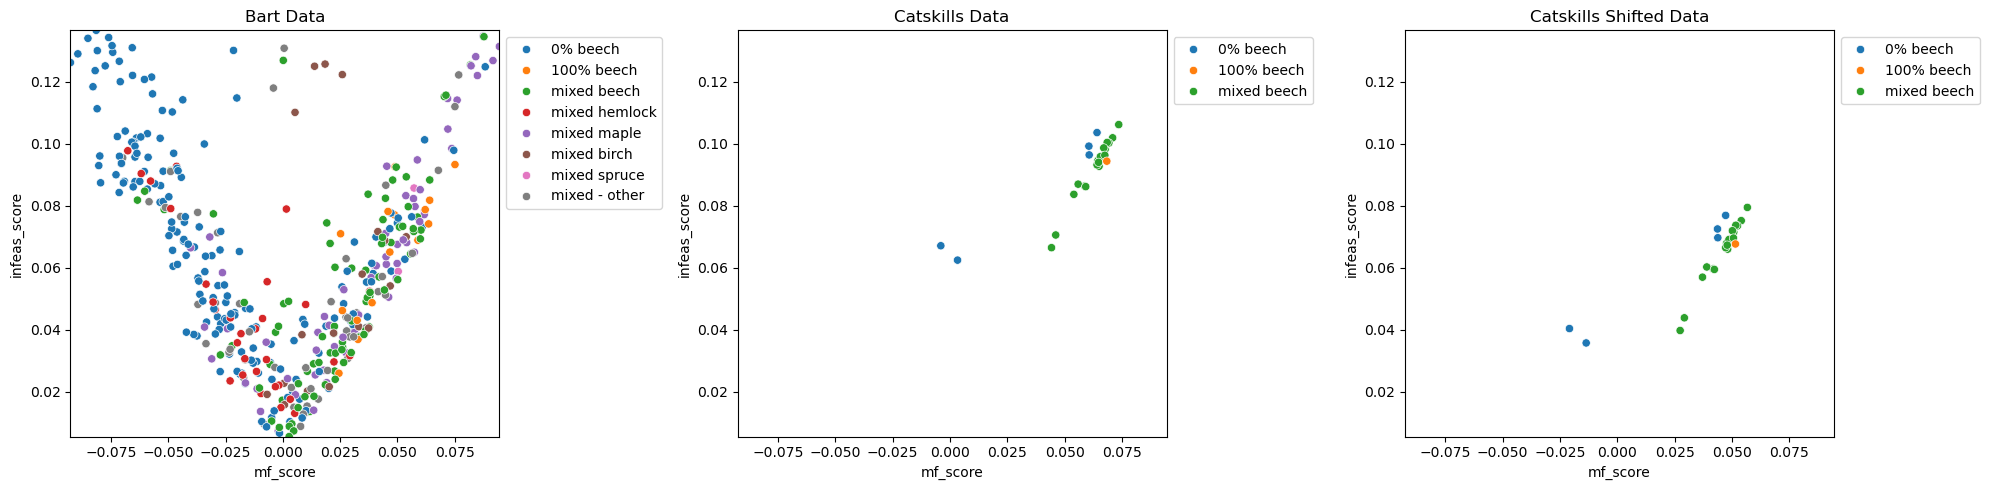

In [27]:
md.plot_input_data()

In [28]:
md.compare_clf_model_results(shift=True) 

In [29]:
md.result_df

model    recall  recall_std  precision  precision_std  \
0      MLP Calibrated  0.876822    0.042181   0.780567       0.042677   
1       RF Calibrated  0.834503    0.078845   0.789940       0.027473   
2  XGBoost Calibrated  0.827029    0.069212   0.760415       0.037086   
0      MLP Calibrated  1.000000         NaN   0.800000            NaN   
1  XGBoost Calibrated  1.000000         NaN   0.833333            NaN   
2       RF Calibrated  1.000000         NaN   0.833333            NaN   

        site  
0       bart  
1       bart  
2       bart  
0  catskills  
1  catskills  
2  catskills

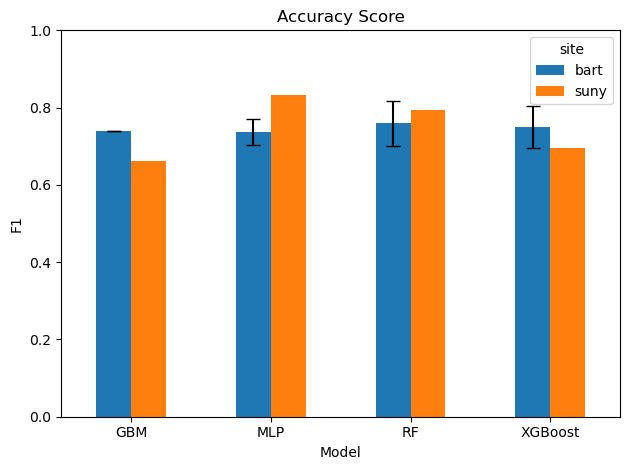

In [35]:
md.plot_clf_model_results()

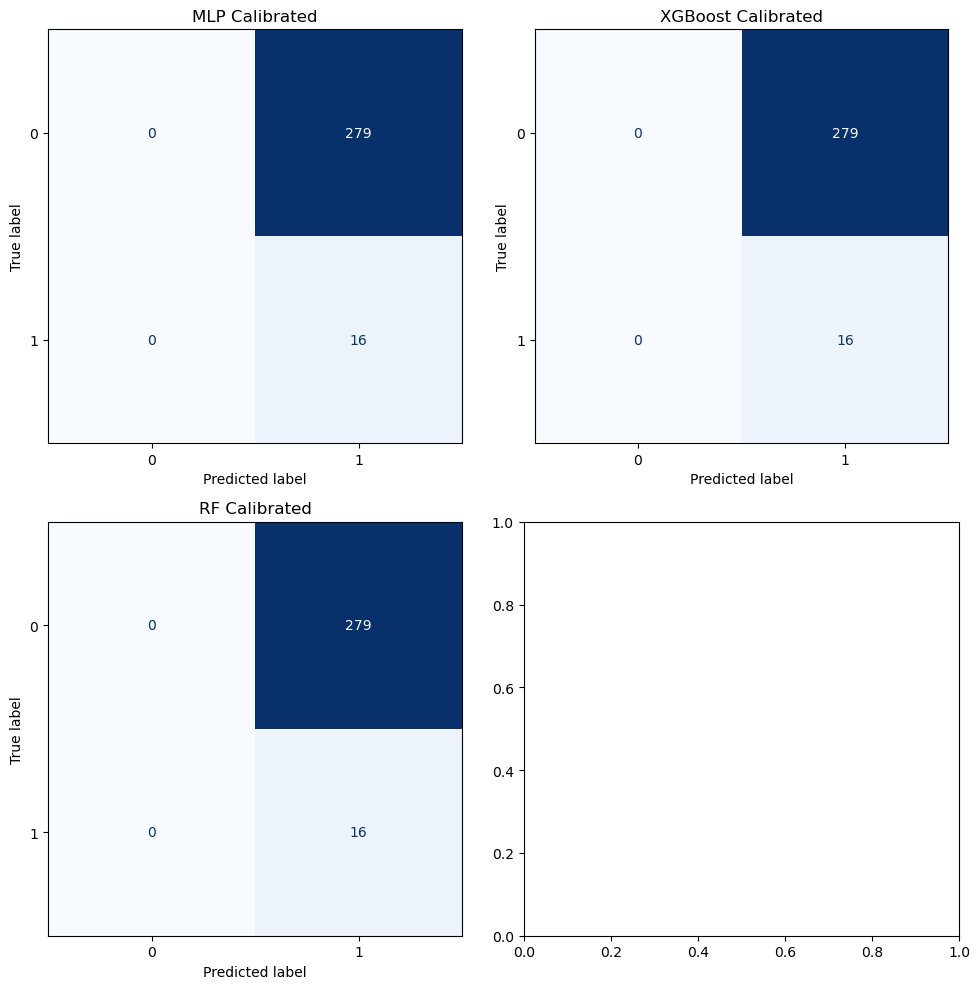

In [74]:
md.plot_confusion_matrices(site='harv')

In [30]:
md.predict_raster(model='clf_rf')

In [36]:
md.prediction = md.prediction.where(md.prediction.y<4660000,drop=True)

In [38]:
m.save(root / 'output' / 'CATSKILLS' / 'predictions_south_ashoken.html')

In [41]:
md.prediction.rio.crs

CRS.from_wkt('PROJCS["NAD83 / UTM zone 18N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26918"]]')

In [43]:
md.prediction.to_netcdf(root/'output' / 'CATSKILLS' / 'predictions_south_ashoken.nc')

In [44]:
md.prediction.rio.to_raster(root/'output' / 'CATSKILLS' / 'predictions_south_ashoken.tif')


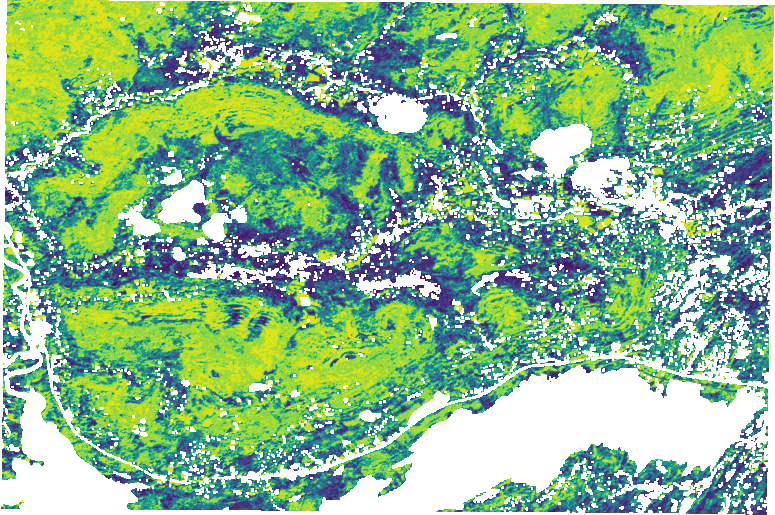

In [37]:
m = md.map_predictions()

m

In [16]:
class ModelBuilder():
    def __init__(self,mtmf_object,target_species,clf_type='binary'):
        self.root = mtmf_object.root
        self.site_name = mtmf_object.site_name
        self.result_array = mtmf_object.result_array
        self.target_species = target_species
        self.df = self.make_training_df()
        
        self.ind_vars = [x for x in self.df.columns if any(y in x for y in ['mf_score','infeas_score'])]
        self.X = self.df.loc[:,self.ind_vars].values
        self.y = self.df.loc[:,clf_type].values

        self.results_log = {'regression':[],'classification':[]}
        self.result_df = None
        self.confusion_matrices = None

        self.reg_param_grids = {
                    "mlp":          {
                                    'hidden_layer_sizes': Integer(100,200), 
                                    'activation':Categorical(['relu']), 
                                    'solver':Categorical(['lbfgs']), # lbfgs more suited to smaller datasets
                                    'alpha': Real(0.0001,0.1,'log-uniform'),  
                                    'max_iter':Integer(10000,50000),  
                                    'max_fun':Integer(10000,15000)
                                    },

                    "randomforest": {"n_estimators": Integer(100,200),
                                    "min_samples_split": Integer(20,50),
                                    'min_samples_leaf': Integer(20,50),
                                    'ccp_alpha':Real(1e-6,0.1,'log-uniform')},

                    "xgboost":      {'max_depth': Integer(1,5),
                                    'learning_rate':Real(1e-6,0.1,'log-uniform'),
                                    'gamma': Real(1e-6,0.1, 'log-uniform'),  # minimum loss reduction required to make another split (gain)
                                    'reg_lambda': Real(1e-6,0.2,'log-uniform'), # L2 regularization of weights
                                    'n_estimators':Integer(50,200)
                                    #'early_stopping_rounds':[10]
                                    },

                    'gbm':          {'learning_rate':Real(0.3,1.0,'log-uniform'),  # factor by which to shrink the contribution of each tree 
                                    'n_estimators':Integer(500,2000),
                                    'max_depth': Integer(1,10),
                                    'n_iter_no_change': Integer(1,30),
                                    'validation_fraction':Real(0.01,0.1,'log-uniform'),
                                    'ccp_alpha':Real(0.01,1.0,'log-uniform')}  # stops pruning when a tree's minimimal cost-complexity is greater than ccp_alpha
                }
        self.clf_param_grids = {
                "mlp":          {
                                'hidden_layer_sizes': Integer(80,110), 
                                'activation':Categorical(['identity', 'logistic', 'tanh', 'relu']), 
                                'solver':Categorical(['lbfgs','sgd','adam']), # lbfgs more suited to smaller datasets
                                'alpha': Real(0.05,0.1,'log-uniform'),  
                                'max_iter':Integer(10000,10100),  
                                'max_fun':Integer(10000,10100)
                                },

                "randomforest": {"n_estimators": Integer(200,1000),
                                "criterion":Categorical(['gini','entropy','log_loss']),
                                "min_samples_split": Integer(2,20),
                                'min_samples_leaf': Integer(1,20),
                                'max_samples': Real(0.1,1.0,'log-uniform'),
                                'ccp_alpha':Real(1e-6,0.1,'log-uniform')
                                },
                "xgboost":      {'max_depth': Integer(1,5),
                                'learning_rate':Real(0.1,0.5,'log-uniform'),
                                'gamma': Real(1e-6,0.1, 'log-uniform'),  # minimum loss reduction required to make another split (gain)
                                'reg_lambda': Real(0.2,0.5,'log-uniform'), # L2 regularization of weights
                                'n_estimators':Integer(10,100),
                                'subsample':Real(1e-6,1.0,'log-uniform'),
                                'scale_pos_weight': Real(0.5,1.0,'log-uniform')  # weight applied to positive class instances
                                #'early_stopping_rounds':[10]
                                },

                'gbm':          {'learning_rate':Real(0.01,0.5,'log-uniform'),  # factor by which to shrink the contribution of each tree 
                                'n_estimators':Integer(1000,2000),
                                'subsample':Real(0.5,1.0,'log-uniform'),
                                'max_depth': Integer(5,15),
                                'n_iter_no_change': Integer(5,15),
                                'validation_fraction':Real(0.01,0.1,'log-uniform'),
                                'ccp_alpha':Real(0.01,1.0,'log-uniform')}  # stops pruning when a tree's minimimal cost-complexity is greater than ccp_alpha
            }

        self.reg_models =  {
                                "mlp": MLPRegressor(),
                                "xgboost": xgb.XGBRegressor(),
                                "gbm": GradientBoostingRegressor(),
                                'randomforest': RandomForestRegressor()
                            }
        self.clf_models = {
                "mlp": MLPClassifier(),
                "xgboost": xgb.XGBClassifier(objective='binary:logistic'),
                "gbm": GradientBoostingClassifier(),
                'randomforest': RandomForestClassifier(class_weight='balanced')
            }

    
    def make_training_df(self):
   
        m = self.result_array

        out_df = pd.DataFrame(rearrange(m.values,'b h w -> (h w) b'),columns=m.band.values)
        out_df = out_df[~np.isnan(out_df).any(axis=1)]

        conditions_binary = [(out_df[f'{self.target_species}_basal_area']==0.0),
                    out_df[f'{self.target_species}_basal_area']>0.0
                    ]
        binary_cats = [0,1]
        out_df['binary'] = np.select(conditions_binary,binary_cats, default=0)
        
        return out_df

    def save_optimized_parameters(self):
        param_dict = {'clf_mlp_params':self.clf_mlp_params,'clf_xg_params':self.clf_xg_params,'clf_rf_params':self.clf_rf_params,'clf_gbm_params':self.clf_gbm_params,'reg_mlp_params':self.reg_mlp_params,'reg_xg_params':self.reg_xg_params,'reg_rf_params':self.reg_rf_params,'reg_gbm_params':self.reg_gbm_params}

        json.dump(param_dict,open(self.root / 'output' / self.site_name.upper() / 'param_dicts.json','w'))
        print(f'tuned params saved to {self.root} / output / {self.site_name.upper()} / param_dicts.json')
    
    def tune_regression_models(self):

        # split training data
        X_train, X_test, y_train, y_test = train_test_split(self.X,self.y,test_size=0.25)


        cv = KFold(n_splits=5, shuffle=True, random_state=0) # random state ensures we compare performance on the same data

        results = []
        for name, model in self.reg_models.items():
            grid_search = BayesSearchCV(
                estimator=model,
                search_spaces=self.reg_param_grids[name],
                return_train_score=True,
                scoring='neg_root_mean_squared_error',
                cv=cv
                ).fit(X_train, y_train)

            param_dict = grid_search.best_params_
            param_dict['model'] = name
            param_dict['test_rmse'] = (np.abs(grid_search.score(X_test,y_test)))
            param_dict['train_rmse'] = (np.abs(grid_search.best_score_))
            results.append(pd.DataFrame(param_dict,index=[param_dict['model']]).drop(columns='model'))
            
        self.results_log['regression'].append(param_dict)
        return pd.concat(results)
    
           
    def tune_classification_models(self):
        # make training data

        X_train, X_test, y_train, y_test = train_test_split(self.X,self.y,test_size=0.25)


        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

        results = []
        for name, model in self.clf_models.items():
            grid_search = BayesSearchCV(
            estimator=model,
            search_spaces=self.clf_param_grids[name],
            return_train_score=True,
            scoring='f1',
            cv=cv
            ).fit(X_train, y_train)

            param_dict = grid_search.best_params_
            param_dict['model'] = name
            param_dict['test_f1'] = (grid_search.score(X_test,y_test))
            param_dict['train_f1'] = (grid_search.best_score_)
            results.append(pd.DataFrame(param_dict,index=[param_dict['model']]).drop(columns='model'))
        self.results_log['classification'].append(results)
        return pd.concat(results)
    
    
        #out_array.to_netcdf(root / 'output' / 'BART' / 'xgboost_probs_bart.nc')

In [66]:
bm = ModelBuilder(bart_mtmf,target_species='beech',clf_type='binary')

In [ ]:
# set parameter search grids for tuning
bm.clf_param_grids['mlp'] = {'hidden_layer_sizes': Integer(low=50, high=100, prior='uniform', transform='normalize'),
 'activation': Categorical(categories=(['relu']), prior=None),
 'solver': Categorical(categories=('lbfgs', 'sgd', 'adam'), prior=None),
 'alpha': Real(low=0.05, high=0.7, prior='log-uniform', transform='normalize'),
 'max_iter': Integer(low=5000, high=10000, prior='uniform', transform='normalize'),
 'max_fun': Integer(low=5000, high=10015, prior='uniform', transform='normalize')}

bm.clf_param_grids['xgboost'] = {'max_depth': Integer(low=1, high=3, prior='uniform', transform='normalize'),
 'learning_rate': Real(low=0.1, high=0.2, prior='log-uniform', transform='normalize'),
 'gamma': Real(low=1e-06, high=1e-4, prior='log-uniform', transform='normalize'),
 'reg_lambda': Real(low=0.1, high=0.3, prior='log-uniform', transform='normalize'),
 'n_estimators': Integer(low=5, high=20, prior='uniform', transform='normalize'),
 'subsample': Real(low=1e-06, high=1.0, prior='log-uniform', transform='normalize'),
 'scale_pos_weight': Real(low=0.8, high=1.0, prior='log-uniform', transform='normalize')}

bm.clf_param_grids['randomforest'] = {'n_estimators': Integer(low=400, high=800, prior='uniform', transform='normalize'),
 'criterion': Categorical(categories=(['entropy']), prior=None),
 'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
 'max_samples': Real(low=0.1, high=0.5, prior='log-uniform', transform='normalize'),
 'ccp_alpha': Real(low=1e-06, high=1e-05, prior='log-uniform', transform='normalize')}

bm.clf_param_grids['gbm'] = {'learning_rate': Real(low=0.1, high=0.5, prior='log-uniform', transform='normalize'),
 'n_estimators': Integer(low=1000, high=1050, prior='uniform', transform='normalize'),
 'subsample': Real(low=0.3, high=0.6, prior='log-uniform', transform='normalize'),
 'max_depth': Integer(low=10, high=20, prior='uniform', transform='normalize'),
 'n_iter_no_change': Integer(low=5, high=15, prior='uniform', transform='normalize'),
 'validation_fraction': Real(low=0.01, high=0.05, prior='log-uniform', transform='normalize'),
 'ccp_alpha': Real(low=0.005, high=0.02, prior='log-uniform', transform='normalize')}


In [37]:
round1 = bm.tune_classification_models()


In [56]:
round2 = bm.tune_classification_models()

In [ ]:
# set optimized parameters
bm.clf_mlp_params = {'hidden_layer_sizes':50, 'activation':'relu','solver':'adam', 'alpha':0.42, 'max_iter':10000, 'max_fun':10015}
bm.clf_xg_params = {'gamma':0,'learning_rate':0.2,'max_depth':3,'n_estimators':20,'reg_lambda':0.1}
bm.clf_gbm_params = {'ccp_alpha':0.0,'learning_rate':0.1,'max_depth':10,'n_estimators':1050,'n_iter_no_change':15,'subsample':0.6,'validation_fraction':0.01}
bm.clf_rf_params = {'n_estimators':700, 'criterion':'entropy', 'max_depth':None, 'min_samples_split':10, 'min_samples_leaf':2,  'ccp_alpha':0.0, 'max_samples':0.35}

# save parameter dictionaries
bm.save_optimized_parameters()

tuned params saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree / output / BART / param_dicts.json


c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users

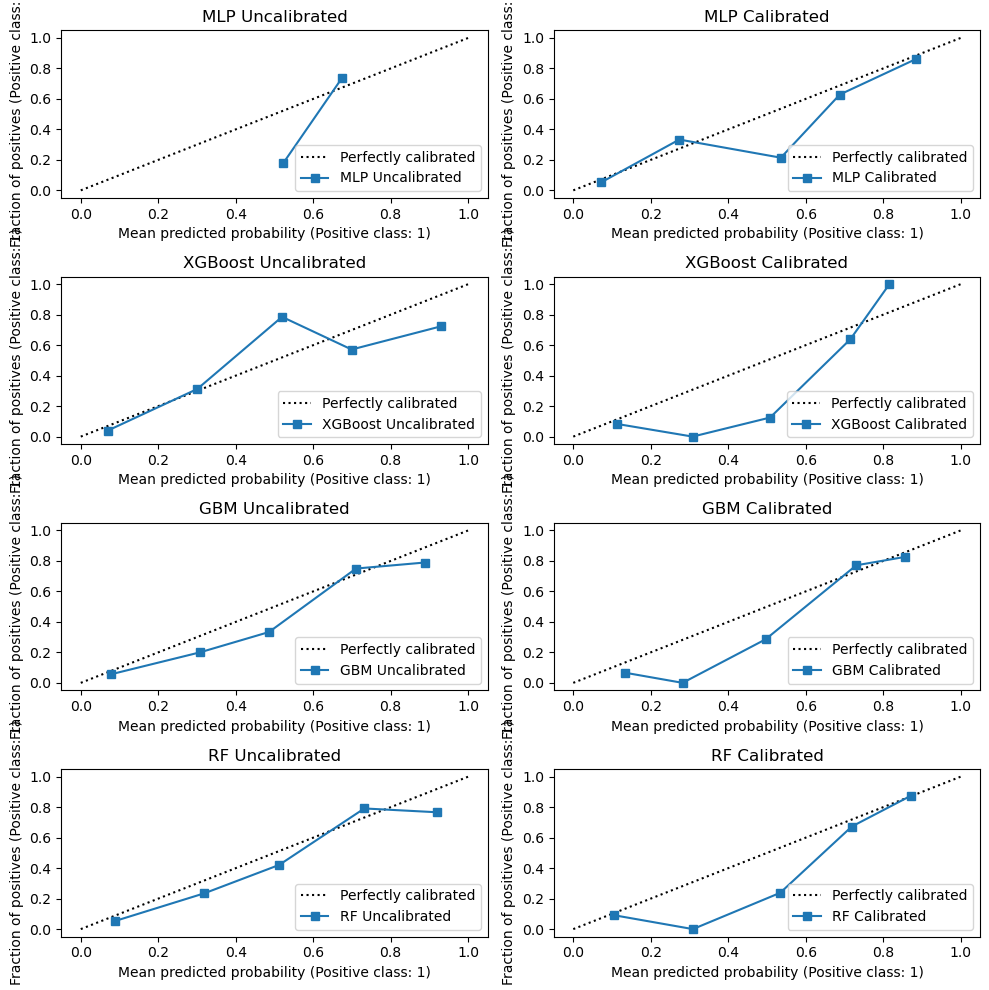

In [68]:
bm.check_clf_model_calibration()

In [ ]:
# try using sklearn.ensemble.StackingRegressor after regressors are all optimized
# or sklearn.multioutput.RegressorChain

def tune_regression_models(df,target_species,param_grids):

    # make training data
    ind_vars = [x for x in df.columns if any(y in x for y in ['mf_score','infeas_score'])]
    X = df.loc[:,ind_vars].values
    y = df.loc[:,f'{target_species}_basal_area'].values
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

    models = {
        "mlp": MLPRegressor(),
        "xgboost": xgb.XGBRegressor(),
        "gbm": GradientBoostingRegressor(),
        'randomforest': RandomForestRegressor()
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    results = []
    for name, model in models.items():
        grid_search = BayesSearchCV(
            estimator=model,
            search_spaces=param_grids[name],
            return_train_score=True,
            scoring='neg_root_mean_squared_error',
            cv=cv
            ).fit(X_train, y_train)

        param_dict = grid_search.best_params_
        param_dict['model'] = name
        param_dict['test_rmse'] = (np.abs(grid_search.score(X_test,y_test)))
        param_dict['train_rmse'] = (np.abs(grid_search.best_score_))
        results.append(pd.DataFrame(param_dict,index=[param_dict['model']]).drop(columns='model'))

    return pd.concat(results)

def add_category_columns(df,target_species):

    conditions_binary = [(df[f'{target_species}_basal_area']==0.0),
                df[f'{target_species}_basal_area']>0.0
                ]
    binary_cats = [0,1]

    conditions_3cats = [(df[f'{target_species}_basal_area']==0.0),
                (df[f'{target_species}_basal_area']>0.0)&(df[f'{target_species}_basal_area']<50.0),
                #(df['basal_area']>=50.0)&(df['basal_area']<=100.0)
                df[f'{target_species}_basal_area']>=50.0
                ]
    three_cats = [0,1,2]

    df['three_categories'] = np.select(conditions_3cats,three_cats, default=0)
    df['binary'] = np.select(conditions_binary,binary_cats, default=0)

    return df




    

In [ ]:
reg_param_grids = {
    "mlp":          {
                    'hidden_layer_sizes': Integer(100,200), 
                    'activation':Categorical(['relu']), 
                    'solver':Categorical(['lbfgs']), # lbfgs more suited to smaller datasets
                    'alpha': Real(0.0001,0.1,'log-uniform'),  
                    'max_iter':Integer(10000,50000),  
                    'max_fun':Integer(10000,15000)
                    },

    "randomforest": {"n_estimators": Integer(100,200),
                     "min_samples_split": Integer(20,50),
                     'min_samples_leaf': Integer(20,50),
                     'ccp_alpha':Real(1e-6,0.1,'log-uniform')},

    "xgboost":      {'max_depth': Integer(1,5),
                    'learning_rate':Real(1e-6,0.1,'log-uniform'),
                    'gamma': Real(1e-6,0.1, 'log-uniform'),  # minimum loss reduction required to make another split (gain)
                    'reg_lambda': Real(1e-6,0.2,'log-uniform'), # L2 regularization of weights
                    'n_estimators':Integer(50,200)
                    #'early_stopping_rounds':[10]
                    },

    'gbm':          {'learning_rate':Real(0.3,1.0,'log-uniform'),  # factor by which to shrink the contribution of each tree 
                    'n_estimators':Integer(500,2000),
                    'max_depth': Integer(1,10),
                    'n_iter_no_change': Integer(1,30),
                    'validation_fraction':Real(0.01,0.1,'log-uniform'),
                    'ccp_alpha':Real(0.01,1.0,'log-uniform')}  # stops pruning when a tree's minimimal cost-complexity is greater than ccp_alpha
}

result_round3 = tune_regression_models(df=beech_df,target_species='beech',param_grids=reg_param_grids)

In [ ]:
# recategorize to 0%, 100%, >50%, <50%

# pipeline: TargetEncoder()


#clf = xgb.XGBClassifier(objective='multi:softmax',eval_metric='auc',early_stopping_rounds=10)  #"multi:softprob"

beech_df = add_category_columns(beech_df,'beech')

In [9]:
beech_df = pd.read_csv(root / 'output' / 'BART' / 'mtmf_df_output.csv')

In [64]:
clf_param_grids = {
    "mlp":          {
                    'hidden_layer_sizes': Integer(80,110), 
                    'activation':Categorical(['identity', 'logistic', 'tanh', 'relu']), 
                    'solver':Categorical(['lbfgs','sgd','adam']), # lbfgs more suited to smaller datasets
                    'alpha': Real(0.05,0.1,'log-uniform'),  
                    'max_iter':Integer(10000,10100),  
                    'max_fun':Integer(10000,10100)
                    },

    "randomforest": {"n_estimators": Integer(200,1000),
                     "criterion":Categorical(['gini','entropy','log_loss']),
                     "min_samples_split": Integer(2,20),
                     'min_samples_leaf': Integer(1,20),
                     'max_samples': Real(0.1,1.0,'log-uniform'),
                     'ccp_alpha':Real(1e-6,0.1,'log-uniform')
                    },
    "xgboost":      {'max_depth': Integer(1,5),
                    'learning_rate':Real(0.1,0.5,'log-uniform'),
                    'gamma': Real(1e-6,0.1, 'log-uniform'),  # minimum loss reduction required to make another split (gain)
                    'reg_lambda': Real(0.2,0.5,'log-uniform'), # L2 regularization of weights
                    'n_estimators':Integer(10,100),
                    'subsample':Real(1e-6,1.0,'log-uniform'),
                    'scale_pos_weight': Real(0.5,1.0,'log-uniform')  # weight applied to positive class instances
                    #'early_stopping_rounds':[10]
                    },

    'gbm':          {'learning_rate':Real(0.01,0.5,'log-uniform'),  # factor by which to shrink the contribution of each tree 
                    'n_estimators':Integer(1000,2000),
                    'subsample':Real(0.5,1.0,'log-uniform'),
                    'max_depth': Integer(5,15),
                    'n_iter_no_change': Integer(5,15),
                    'validation_fraction':Real(0.01,0.1,'log-uniform'),
                    'ccp_alpha':Real(0.01,1.0,'log-uniform')}  # stops pruning when a tree's minimimal cost-complexity is greater than ccp_alpha
}

In [ ]:
def tune_classification_models(df,clf_type,param_grids,models):
    # make training data
    ind_vars = [x for x in df.columns if any(y in x for y in ['mf_score','infeas_score'])]
    X = df.loc[:,ind_vars].values
    y = df.loc[:,clf_type].values
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # random state ensures we compare performance on the same data

    results = []
    for name, model in models.items():
        grid_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_grids[name],
        return_train_score=True,
        scoring='f1',
        cv=cv
        ).fit(X_train, y_train)


    
        param_dict = grid_search.best_params_
        param_dict['model'] = name
        param_dict['test_f1'] = (grid_search.score(X_test,y_test))
        param_dict['train_f1'] = (grid_search.best_score_)
        results.append(pd.DataFrame(param_dict,index=[param_dict['model']]).drop(columns='model'))
    
    return pd.concat(results)
    

In [87]:
clf_models = {
      "mlp": MLPClassifier(),
      "xgboost": xgb.XGBClassifier(objective='binary:logistic'),
      "gbm": GradientBoostingClassifier(),
      'randomforest': RandomForestClassifier(max_features=None,class_weight='balanced')
  }

round3 = tune_classification_models(beech_df,clf_type='binary',param_grids=clf_param_grids,models=clf_models)

In [ ]:
# CalibratedClassifierCV


from mlxtend.classifier import StackingCVClassifier

# function: compare_optimized_models


# df = beech_df
# ind_vars = [x for x in df.columns if any(y in x for y in ['mf_score','infeas_score'])]
# X = df.loc[:,ind_vars].values
# y = df.loc[:,'binary'].values
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)


# # define models with optimized parameters
# mlp = MLPClassifier(hidden_layer_sizes=self.clf_mlp_params['hidden_layer_sizes'],max_fun=self.clf_mlp_params['max_fun'],max_iter=self.clf_mlp_params['max_iter'],activation=self.clf_mlp_params['activation'],solver=self.clf_mlp_params['solver'],alpha=self.clf_mlp_params['alpha'])

# xgboost = xgb.XGBClassifier(objective='binary:logistic',gamma=self.clf_xg_params['gamma'],learning_rate=self.clf_xg_params['learning_rate'],max_depth=self.clf_xg_params['max_depth'],n_estimators=self.clf_xg_params['n_estimators'],reg_lambda=self.clf_xg_params['reg_lambda'])

# gbm = GradientBoostingClassifier(ccp_alpha=self.clf_gbm_params['ccp_alpha'],learning_rate=self.clf_gbm_params['learning_rate'],max_depth=self.clf_gbm_params['max_depth'],n_estimators=self.clf_gbm_params['n_estimators'],n_iter_no_change=self.clf_gbm_params['n_iter_no_change'],subsample=self.clf_gbm_params['subsample'],validation_fraction=self.clf_gbm_params['validation_fraction'])

# rf = RandomForestClassifier(class_weight='balanced',ccp_alpha=self.clf_rf_params['ccp_alpha'],n_estimators=self.clf_rf_params['n_estimators'],criterion=self.clf_rf_params['criterion'],max_samples=self.clf_rf_params['max_samples'],min_samples_leaf=self.clf_rf_params['min_samples_leaf'],min_samples_split=self.clf_rf_params['min_samples_split'])

# # ensure outputs correspond to actual probablities
# mlp_cal = CalibratedClassifierCV(mlp,cv=5,method='sigmoid')
# xgboost_cal = CalibratedClassifierCV(xgboost,cv=5,method='sigmoid')
# gbm_cal = CalibratedClassifierCV(gbm,cv=5,method='sigmoid')
# rf_cal = CalibratedClassifierCV(rf,cv=5,method='sigmoid')

# # fit models
# mlp_cal.fit(X_train,y_train)
# xgboost_cal.fit(X_train,y_train)
# gbm_cal.fit(X_train,y_train)
# rf_cal.fit(X_train,y_train)

# mlp_preds = mlp_cal.predict_proba(X_test)

### plot results




In [ ]:
df = beech_df
ind_vars = [x for x in df.columns if any(y in x for y in ['mf_score','infeas_score'])]
X = df.loc[:,ind_vars].values
y = df.loc[:,'binary'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

clf_mlp_params = {'hidden_layer_sizes':103,'max_fun':100003,'max_iter':10083,'activation':'relu','solver':'adam','alpha':0.09}
clf_xg_params = {'gamma':0.0,'learning_rate':0.13,'max_depth':1,'n_estimators':50,'reg_lambda':0.5}
clf_gbm_params = {'ccp_alpha':0.01,'learning_rate':0.5,'max_depth':5,'n_estimators':2000,'n_iter_no_change':6,'subsample':0.8,'validation_fraction':0.1}
clf_rf_params = {'ccp_alpha':0.0,'n_estimators':700,'criterion':'entropy','max_samples':0.1,'min_samples_leaf':1,'min_samples_split':6}


# define models with optimized parameters
mlp = MLPClassifier(hidden_layer_sizes=clf_mlp_params['hidden_layer_sizes'],max_fun=clf_mlp_params['max_fun'],max_iter=clf_mlp_params['max_iter'],activation=clf_mlp_params['activation'],solver=clf_mlp_params['solver'],alpha=clf_mlp_params['alpha'])

xgboost = xgb.XGBClassifier(objective='binary:logistic',gamma=clf_xg_params['gamma'],learning_rate=clf_xg_params['learning_rate'],max_depth=clf_xg_params['max_depth'],n_estimators=clf_xg_params['n_estimators'],reg_lambda=clf_xg_params['reg_lambda'])

gbm = GradientBoostingClassifier(ccp_alpha=clf_gbm_params['ccp_alpha'],learning_rate=clf_gbm_params['learning_rate'],max_depth=clf_gbm_params['max_depth'],n_estimators=clf_gbm_params['n_estimators'],n_iter_no_change=clf_gbm_params['n_iter_no_change'],subsample=clf_gbm_params['subsample'],validation_fraction=clf_gbm_params['validation_fraction'])

rf = RandomForestClassifier(class_weight='balanced',ccp_alpha=clf_rf_params['ccp_alpha'],n_estimators=clf_rf_params['n_estimators'],criterion=clf_rf_params['criterion'],max_samples=clf_rf_params['max_samples'],min_samples_leaf=clf_rf_params['min_samples_leaf'],min_samples_split=clf_rf_params['min_samples_split'])

# calibrate output to actual probablities
mlp_cal = CalibratedClassifierCV(mlp,cv=5,method='isotonic')
xgboost_cal = CalibratedClassifierCV(xgboost,cv=5,method='isotonic')
gbm_cal = CalibratedClassifierCV(gbm,cv=5,method='isotonic')
rf_cal = CalibratedClassifierCV(rf,cv=5,method='isotonic')

# fit calibrated models
mlp_cal.fit(X_train,y_train)
xgboost_cal.fit(X_train,y_train)
gbm_cal.fit(X_train,y_train)
rf_cal.fit(X_train,y_train)

# fit regular models
mlp.fit(X_train,y_train)
xgboost.fit(X_train,y_train)
gbm.fit(X_train,y_train)
rf.fit(X_train,y_train)



In [ ]:
# fit calibrated models
mlp_cal.fit(X_train,y_train)
xgboost_cal.fit(X_train,y_train)
gbm_cal.fit(X_train,y_train)
rf_cal.fit(X_train,y_train)

# fit regular models
mlp.fit(X_train,y_train)
xgboost.fit(X_train,y_train)
gbm.fit(X_train,y_train)
rf.fit(X_train,y_train)

models = {
    "MLP Uncalibrated": mlp,
    "MLP Calibrated" : mlp_cal,
    "XGBoost Uncalibrated": xgboost,
    "XGBoost Calibrated" : xgboost_cal,
    "GBM Uncalibrated": gbm,
    "GBM Calibrated" : gbm_cal,
    "RF Uncalibrated": rf,
    "RF Calibrated": rf_cal

}
# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(10, 10))  # 2x4 
axes = axes.flatten()  # flatten for indexing

# Loop through models and plot CalibrationDisplay
for idx, (name, model) in enumerate(models.items()):
    CalibrationDisplay.from_estimator(model, X_test, y_test, ax=axes[idx],name=name)
    axes[idx].set_title(name)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# compare mean performance over 5 training iterations (on 5 different subsets of data)

models = {
    "MLP Calibrated" : mlp_cal,
    "XGBoost Calibrated" : xgboost_cal,
    "GBM Calibrated" : gbm_cal,
    "RF Calibrated": rf_cal
}

# results = {'model': [],'score':[]}
# for name, model in models.items():
#     for i in range(5):
#         X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
#         model.fit(X_train,y_train)
#         score = model.score(X_test,y_test)
#         results['model'].append(name)
#         results['score'].append(score)

# r = pd.DataFrame(results)

# r = r.groupby('model').agg({'score':['mean','std']}).reset_index()
# r.columns = r.columns.droplevel(0)
# r.columns = ['model','mean_score','std']

# ax = r.plot(x='model',y='mean_score',yerr='std',capsize=5,kind='bar',title='Mean F1',xlabel='Model',ylabel='F1',legend=False)
# ax.set_ylim(0.0,1.0)
# ax.set_xticklabels([x.split(' ')[0] for x in r['model']],rotation=0)
# plt.show()
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x4 
axes = axes.flatten() 

for idx, (name, model) in enumerate(models.items()):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot(ax=axes[idx], cmap='Blues',colorbar=False) 
    axes[idx].set_title(name)

plt.tight_layout() 
plt.show()

# plt.show()

In [ ]:
ind_vars = [x for x in df.columns if any(y in x for y in ['mf_score','infeas_score'])]
X = beech_df.loc[:,ind_vars].values
y = beech_df.loc[:,'binary'].values



#mtmf_df_dropna = mtmf_df_dropna.loc[:,ind_vars].values

# get indices of dropped nas to replace them later
 

In [ ]:


mtmf_df = pd.DataFrame(rearrange(bart_mtmf.result_array.values,'b h w -> (h w) b'),columns=bart_mtmf.result_array.band.values)
mtmf_df = mtmf_df.loc[:,ind_vars]

na_indices = np.where(np.isnan(mtmf_df))
row_indices = np.unique(na_indices[0])

mtmf_df_dropna = mtmf_df[~np.isnan(mtmf_df).any(axis=1)].values

xgboost_cal.fit(X,y) # fit on all data
predicted_probs = xgboost_cal.predict_proba(mtmf_df_dropna)[:,1]

output = np.full((mtmf_df.shape[0]), np.nan)  # create array of correct shape

# Fill in the rows that were not NaN
non_nan_indices = np.setdiff1d(np.arange(mtmf_df.shape[0]), row_indices)  # get indices that don't have na values
output[non_nan_indices] = predicted_probs

shape = bart_mtmf.result_array.shape
output = output.reshape((shape[1],shape[2]) + (-1,)).squeeze()
out_array = xr.DataArray(output, coords={'y': bart_mtmf.result_array.y.values, 'x': bart_mtmf.result_array.x.values},dims=['y','x'])

out_array = out_array.rio.write_crs(26919).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
out_array.to_netcdf(root / 'output' / 'BART' / 'xgboost_probs_bart.nc')

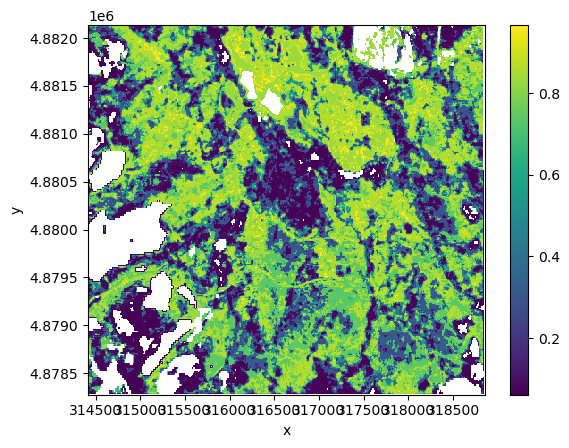

In [ ]:


out_array.plot()  # color ramp = probability that pixel contains beech

In [ ]:
# from Marconi: stacked classifiers


#define models
rf2 = make_pipeline(StandardScaler(),
                    RandomForestClassifier(random_state=0, oob_score = True,
        n_estimators = 300, max_features = 'sqrt', criterion = 'entropy'))


knn2 = make_pipeline(StandardScaler(),
                     KNeighborsClassifier(weights = 'distance', 
                                          p=1, n_neighbors=20))
gb2 = make_pipeline(StandardScaler(),
                    HistGradientBoostingClassifier(random_state=0, 
                    max_iter = 1000, learning_rate = 0.01, 
                max_depth = 25, loss = 'categorical_crossentropy', 
                l2_regularization = 0.5))
mlpc2 = make_pipeline(StandardScaler(), 
                      MLPClassifier(random_state=0, 
                                    beta_2=0.9, max_iter = 1200))

from sklearn.naive_bayes import GaussianNB
bayes2 = make_pipeline(StandardScaler(), GaussianNB())

bsvc2 =make_pipeline(StandardScaler(),
                     BaggingClassifier(
                         base_estimator=SVC(probability = True, C = 1000), 
                        n_jobs = 1, random_state=0))

logc = LogisticRegression(penalty = "elasticnet", solver = "saga", 
                          max_iter = 10000, n_jobs=3, l1_ratio = 0.5)


logc = LogisticRegression(penalty = "elasticnet", solver = "saga", 
                          max_iter = 10000, n_jobs=3, l1_ratio = 0.5)
from mlxtend.classifier import StackingCVClassifier
clf_bl2 = StackingCVClassifier(classifiers = [rf2, gb2, bsvc2, mlpc2, knn2],
            use_probas=True, cv = 3, n_jobs =1,
            meta_classifier= logc)

clf_bl2.fit(X_res, y_res.taxonID.ravel())
print(clf_bl2.score(X_test, y_test['taxonID'].ravel()))

predict_an = clf_bl2.predict_proba(X_test)

In [ ]:
### pixel time series

red_cat = cat_data.aligned_data.sel(band='B04')
nir_cat = cat_data.aligned_data.sel(band='B08')
blue_cat = cat_data.aligned_data.sel(band='B02')

evi_cat = 2.5 * ((nir_cat - red_cat) / (nir_cat + 6 * red_cat - 7.5 * blue_cat + 1))
ba = cat_data.basal_area['beech_basal_area']
evi_beech = evi_cat.where(ba==100.0)
evi_nonbeech = evi_cat.where(ba<100.0)

df = rearrange(evi_nonbeech.values,'t h w -> (h w) t')
df2 = df[~np.isnan(df).any(axis=1)]
df2 = pd.DataFrame(df2)
df2 = df2.T
df2['months'] = ['April','May','June','July','September','October']

df3 = df2.iloc[1:,:-1] # remove month column to calculate min/mix normalization
df3_norm = (df3 - df3.min()) / (df3.max() - df3.min())
df3_norm['months'] = ['May','June','July','September','October'] # removing April necessary for alignment

# phenological offset - actually emphasizes difference between sites?
df4 = df2.iloc[:,:-1]
df4_baseline = df4.subtract(df4.iloc[0], axis=1)
amplitude = df4.max() - df4.iloc[0]
phen_offset_norm = df4_baseline.divide(amplitude, axis=1)
phen_offset_norm['months'] = ['April','May','June','July','September','October']

# create color dictionary of {labels:color}
#pixel_labels = (['north']*11) + (['south']*4)  # last four are southern location
pixel_labels = (['north']*6) + (['south']*3)
unique_labels = pd.Series(pixel_labels).unique()
palette = sns.color_palette("husl", len(unique_labels))
color_dict = dict(zip(unique_labels, palette))

# plot results
plot_df = phen_offset_norm
title = 'NonBeech Pixels EVI Time Series - phenological offset'

plt.figure(figsize=(8,4))
for pixel in plot_df.columns[:-1]:
    label = pixel_labels[plot_df.columns.get_loc(pixel)]  # get label for this pixel
    color = color_dict[label]
    plt.plot(plot_df.months, plot_df[pixel], color=color, alpha=0.4)

# Create legend
handles = [
    plt.Line2D([], [], color=color, label=label)
    for label, color in color_dict.items()
]
plt.legend(handles=handles, title="Location")
plt.title(title)

plt.xlabel("Time")
plt.ylabel("EVI")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# old class

class DataStack():
    """Class containing processed data for input into minimum noise fraction"""
    def __init__(self,root,year,site_name,epsg):
        self.root = root
        #os.makedirs(self.root / 'sentinel_data' / site_name,exist_ok=True)
        self.folder = site_name
        self.year = year
        self.site_name = site_name
        self.epsg = int(epsg)

        b = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}.nc')
        self.input_data = b.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

        self.y_coords = self.input_data.y.values
        self.x_coords = self.input_data.x.values

        self.season_data = None

        f1 = self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_aligned_bands.nc'
        if os.path.isfile(f1):
            self.aligned_data = xr.open_dataarray(f1)
        else:
            self.aligned_data = None 

        f2 = self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_variables.nc'
        if os.path.isfile(f2):
            self.all_variables = xr.open_dataarray(f2)
        else:
            self.all_variables = None

        f3 = self.root / 'output' / self.site_name.upper() / f'basal_area_{self.site_name.upper()}.nc'
        if os.path.isfile(f3):
            aa = xr.open_dataset(f3)
            self.basal_area = aa    # dataset containing basal area/categories for each species
        else:
            self.basal_area = None
            
        
        f4 = self.root / 'output' / self.site_name.upper() / f'{self.site_name.upper()}_endmember_beech.gpkg'
        if os.path.isfile(f4):
            self.endmember_manual = gpd.read_file(f4)
        else:
            self.endmember_manual = None
        
        self.labels = [os.path.join(self.root / 'output' / self.site_name.upper(),x) for x in os.listdir(self.root / 'output' / self.site_name.upper()) if x.endswith('labels.csv')]
        
        f5 = self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}_diffs_summerminusfall.nc)'
        if os.path.isfile(f5):
            self.diffs = xr.open_dataarray(f5)
        else:
            self.diffs = None

        self.mnf_input = None

    def plot_input_data(self,band):
        self.input_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)

    def plot_season_data(self,band):
        if self.season_data is not None:
            self.season_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)
        else:
            print('need to run method: select_season_data()')
    
    def plot_aligned_data(self,band):
        if self.aligned_data is not None:
            self.aligned_data.isel(band=band).plot(col='time',col_wrap=4,robust=True)
        else:
            print('need to run method: coregister_data()')
    
    def select_season_data(self,date_list): # input date_list based on manual inspection of input data
        e = [str(x) for x in self.input_data.time.values if any(date in str(x) for date in date_list)]
        self.season_data =  self.input_data.sel(time=e)
    
    def get_gradient(self,im) :
        # Calculate the x and y gradients using Sobel operator
        grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
        grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
        # Combine the two gradients
        grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)

        return grad
    
    def coregister_data(self):
    
        # replace nas with 0
        b_sel = self.season_data.where(~np.isnan(self.season_data), other=0)
        # create reference image: mean of all temporal steps
        reference_image = self.season_data.mean(dim=['band','time'])
        # replace na with 0 
        reference_image = reference_image.where(~np.isnan(reference_image), other=0)

        # convert input data to numpy float32 numpy arrays
        reference_image = np.float32(reference_image.to_numpy())
        im = np.float32(b_sel.to_numpy())

        # define dimensions for output image
        height = b_sel.shape[2]
        width = b_sel.shape[3]
        time = b_sel.shape[0]
        band = b_sel.shape[1]

        ## Define motion model
        warp_mode = cv2.MOTION_AFFINE
       
        # Set the stopping criteria for the algorithm.
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

        # Create empty array of correct size for new aligned images
        im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )

        # loop over time and band dimensions and apply coregistration to each band
        
        for i in tqdm(range(0,time)):
            # set empty warp matrix
            warp_matrix = np.eye(2, 3, dtype=np.float32)
            # calculate warp matrix based on red band
            (_, warp_matrix) = cv2.findTransformECC(self.get_gradient(reference_image), self.get_gradient(im[i,2,:,:]),warp_matrix, warp_mode, criteria)    
            # apply transformation to each band 
            for j in range(0,band):                                                 
                im_aligned[i,j,:,:] = cv2.warpAffine(im[i,j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
                

        b_align = xr.DataArray(im_aligned, 
                      coords={'time':b_sel.time,'band': b_sel.band,'y': b_sel.y,'x':b_sel.x}, 
                      dims=['time','band','y','x'])
        b_align = b_align.where(b_align!=0, other=np.nan) # reset 0 values to na
    

        self.aligned_data = b_align
        b_align.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_aligned_bands.nc')
        print(f'coregisterd bands saves to {self.root} / sentinel_data / {self.folder} / {self.year}_{self.site_name}_aligned_bands.nc')

    
    def remove_outliers(self,a,norm=True):  
        a = a.where(np.isfinite(a),np.nan)
        if norm == True:
            a = a.where((a >= -1) & (a <= 1))
        else:
            a = a.where((a >= 0) & (a <= 8))
        return a
    
    # TODO: add new function to normalize bands through time before calculating variables
    
    def add_all_variables(self,num_months,num_of_peak_evi_month): # number of months
        if self.aligned_data is None:
            print('need to run method: coregister_data()')
        else:
        # separate all bands onto 1 dimension
            t = np.arange(0,num_months)
            season_list = [f'month{x}' for x in t]

            array_list1 = list()
            for i, season in enumerate(season_list):
                t = self.aligned_data.isel(time=i).reset_coords('time',drop=True)
                t = t.assign_coords({'band':[f'{x}_{season}' for x in self.aligned_data.band.values]})
                array_list1.append(t)

            m1 = xr.concat(array_list1,dim='band')

            # calculate evi, lswi, slavi, psri for each season 
            #season_list = ['month1','month2','month3', etc....]
            array_list2 = list()
            for i in range(0,num_months):
                blue = array_list1[i].sel(band=f'B02_{season_list[i]}')
                green = array_list1[i].sel(band=f'B03_{season_list[i]}')
                red = array_list1[i].sel(band=f'B04_{season_list[i]}')
                nir = array_list1[i].sel(band=f'B8A_{season_list[i]}')
                sw1 = array_list1[i].sel(band=f'B11_{season_list[i]}')
                sw2 = array_list1[i].sel(band=f'B12_{season_list[i]}')
                re2 = array_list1[i].sel(band=f'B06_{season_list[i]}')


                evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1)).expand_dims({'band':[f'evi_{season_list[i]}']}) # range -1 - 1
                evi = self.remove_outliers(evi)

                lswi = (nir - sw1)/(nir + sw1).expand_dims({'band':[f'lswi_{season_list[i]}']}) # range -1 to 1
                lswi = self.remove_outliers(lswi)

                slavi = nir/(red + sw2).expand_dims({'band':[f'slavi_{season_list[i]}']}) # range 0 - 8
                slavi = self.remove_outliers(slavi,norm=False)

                psri = (red - blue)/re2.expand_dims({'band':[f'psri_{season_list[i]}']}) # range -1 to 1
                psri = self.remove_outliers(psri)

                bright = (0.3510*blue)+(0.3813*green)+(0.3437*red)+(0.7196*nir)+(0.2396*sw1)+(0.1949*sw2).expand_dims({'band':[f'bright_{season_list[i]}']})
                bright = self.remove_outliers(bright)

                wet = (0.2578*blue)+(0.2305*green)+(0.0883*red)+(0.1071*nir)+(-0.7611*sw1)+(-0.5308*sw2).expand_dims({'band':[f'wet_{season_list[i]}']})
                wet = self.remove_outliers(wet)

                green = (-0.3599*blue)+(-0.3533*green)+(-0.4734*red)+(0.6633*nir)+(0.0087*sw1)+(-0.2856*sw2).expand_dims({'band':[f'green_{season_list[i]}']})
                green = self.remove_outliers(green)

                season_vi = xr.concat([evi,lswi,slavi,psri,bright,wet,green],dim='band')

                array_list2.append(season_vi)

            m2 = xr.concat(array_list2,dim='band')

            m3 = xr.concat([m1,m2],dim='band')

            ## mask non-forest pixels
            self.all_variables = m3.where(m3.sel(band=f'evi_month{num_of_peak_evi_month}')>0.5,other=np.nan)
            
            # save
            self.all_variables.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_variables.nc')
            print(f'variables saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_variables.nc')



    # calculate differences for indices of given two months
    def get_season_differences(self,first,second,desc):
        array_list = list()
        for vi in ['evi', 'lswi', 'slavi','psri','wet','bright','green']:
            d = self.all_variables.sel(band=f'{vi}_{first}') - self.all_variables.sel(band=f'{vi}_{second}')
            d = d.expand_dims({'band':[f'{vi}_{first}_{second}_diff']})
            array_list.append(d)
        
        self.diffs = xr.concat(array_list,dim='band')
        self.diffs.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{desc}.nc')
        print(f'diffs saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_diffs_{desc}.nc')


    def run_pca(self,n,monthstouse,bandstouse,diff_desc,output_desc,save=False):
        
        e = [x for x in self.all_variables.band.values if (any(y in x for y in monthstouse) & any(z in x for z in bandstouse))]
        a1 = self.all_variables.sel(band=e)

        d_list = []
        for desc in diff_desc:
            d1 = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{desc}.nc')
            f = [x for x in d1.band.values if any(y in x for y in bandstouse)]
            d1 = d1.sel(band=f)
            d_list.append(d1)
        d = xr.concat(d_list,dim='band')

        a2 = xr.concat([a1,d],dim='band')
        ###############################################################################
        ##########################################temporary#############################
        #a2 = a2.where(a2.y<4660000) 
        ################################################################################
        ################################################################################
        a = a2.values 

        ### crop to northern sites only

        a_2d = rearrange(a, 'c h w -> (h w) c')
        # drop all na from data
        a2d_dropna = a_2d[~np.isnan(a_2d).any(axis=1)]
        # get indices of dropped nas to replace them later
        na_indices = np.where(np.isnan(a_2d))
        row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

        # rescale data around approximate mean of 0
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(a2d_dropna)

        
        pca = PCA(n_components=n)
        pca.fit(data_scaled)
        pca_data = pca.transform(data_scaled)
        print(f'explained variance: {np.cumsum(pca.explained_variance_ratio_)}')
        
            
        # replace nans that were dropped earlier
        output_array = np.full((a_2d.shape[0],pca_data.shape[1]), np.nan)  # create array of correct shape

        # Fill in the rows that were not NaN
        non_nan_indices = np.setdiff1d(np.arange(a_2d.shape[0]), row_indices)  # get indices that don't have na values
        output_array[non_nan_indices] = pca_data

        # # reshape to original dimensions
        height = self.all_variables.shape[1]
        width = self.all_variables.shape[2]
        new_pca_data = rearrange(output_array, '(h w) c -> c h w', h=height, w=width)
        pca_array = xr.DataArray(new_pca_data, 
                            coords={'band': np.arange(0,n),'y': self.all_variables.y,'x': self.all_variables.x}, 
                            dims=['band','y','x'])
        # todo: return object with explained variance, plot function etc.
        if save is True:
            pca_array.to_netcdf(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_pca_{output_desc}.nc')
            print(f'pca saved to {self.root}/sentinel_data/{self.folder}/{self.year}_{self.site_name}_pca_{output_desc}.nc')
        
        return pca, pca_array


    # def plot_pca(self,rows,n_comps):
    #     fig = plt.subplots(figsize=(20,5))
    #     for i in range(0,n_comps):
    #         plt.subplot(rows, n_comps, i+1)
    #         self.pca.isel(band=i).plot()
    #     plt.show()

    def make_mnf_input(self, v1, v2,month,diff_desc):
        """
        Assemble given version for input to MNF(), assuming existence of saved requisite .nc files

        v1 = 'gs' or 'ssf' (growing season or spring-summmer-fall)
        v2 = 'tc' or 'nontc' (tasseled cap or non tasseled cap)
        month = 'month0, month1.....monthn' specifies month for which to include all bands and indices
        diff_desc = which diff version to use

        """
        # select specified month
        if len(month) == 1:
            e = [x for x in self.all_variables.band.values if month[0] in x]
            a = self.all_variables.sel(band=e)
        else:
            e = [x for x in self.all_variables.band.values if (any(y in x for y in month))]
            a = self.all_variables.sel(band=e)
        
        if v2 == 'tc':
            f = [x for x in a.band.values if any(y in x for y in ['B','evi','bright','green','wet'])]
            a = a.sel(band=f)
        else:
            f = [x for x in a.band.values if any(y in x for y in ['B','evi','lswi','slavi','psri'])]
            a = a.sel(band=f)

        #a = a.where(a.y<4660000) ################ TEMPORARY LINE####################3
        pca = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_pca_{v1}_{v2}.nc')
        #pca = pca.isel(band=slice(0,10))

        b = xr.concat([a,pca],dim='band')

        if len(diff_desc) > 1:

            d = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{diff_desc[0]}.nc')

            if v2 == 'tc':
                f = [x for x in d.band.values if any(y in x for y in ['evi','bright','green','wet'])]
                d = d.sel(band=f)
            else:
                f = [x for x in d.band.values if any(y in x for y in ['evi','lswi','slavi','psri'])]
                d = d.sel(band=f)

            c = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{diff_desc[1]}.nc')

            if v2 == 'tc':
                f = [x for x in c.band.values if any(y in x for y in ['evi','bright','green','wet'])]
                c = c.sel(band=f)
            else:
                f = [x for x in c.band.values if any(y in x for y in ['evi','lswi','slavi','psri'])]
                c = c.sel(band=f)
                b = xr.concat([a,d,c,pca],dim='band')

        else:
            d = xr.open_dataarray(self.root / 'sentinel_data' / self.folder / f'{self.year}_{self.site_name}_diffs_{diff_desc[0]}.nc')

            if v2 == 'tc':
                    f = [x for x in d.band.values if any(y in x for y in ['evi','bright','green','wet'])]
                    d = d.sel(band=f)
            else:
                f = [x for x in d.band.values if any(y in x for y in ['evi','lswi','slavi','psri'])]
                d = d.sel(band=f)
            #d = d.where(d.y<4660000) ##############TEMPORARY LINE#####################3
            b = xr.concat([a,d,pca],dim='band')

        self.mnf_input = b

           

